This code file is to load, process and merge arrivals data, weather at Syracuse, departures data and weather at origin airport.

We also process and prepare prediction csv file for multiple sue cases.

In [1]:
# Generic inputs for most ML tasks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import tree
# import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier

pd.options.display.float_format = '{:,.2f}'.format

# setup interactive notebook mode
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display, HTML

# imports for path
import os
from pathlib import Path

In [2]:
# Defining the path to the parent data folder
data_path = Path.joinpath(Path.cwd(), "data")
data_path

PosixPath('/Users/gvssriram/Desktop/MS/ML/Project/project_24/data')

# Arrivals

In [3]:
# Defining the path to the airlines folder inside "data" folder
airlines_data_path = data_path.joinpath("arrivals")
airlines_data_path

PosixPath('/Users/gvssriram/Desktop/MS/ML/Project/project_24/data/arrivals')

In [4]:
# Reading data files from the airlines data folder

df = pd.DataFrame()

for file in os.listdir(airlines_data_path):
    print(file)
    df_ = pd.read_csv(airlines_data_path.joinpath(file), skiprows=[0, 1, 2, 3, 4, 5, 6], parse_dates=True, dtype=str)
    # print(df.head())
    df = pd.concat([df, df_])

df.head()

Detailed_Statistics_Arrivals (16).csv
Detailed_Statistics_Arrivals (4).csv
Detailed_Statistics_Arrivals (8).csv
Detailed_Statistics_Arrivals (9).csv
Detailed_Statistics_Arrivals (5).csv
Detailed_Statistics_Arrivals (10).csv
Detailed_Statistics_Arrivals (2).csv
Detailed_Statistics_Arrivals (3).csv
Detailed_Statistics_Arrivals (11).csv
Detailed_Statistics_Arrivals (12).csv
Detailed_Statistics_Arrivals (13).csv
Detailed_Statistics_Arrivals (1).csv
Detailed_Statistics_Arrivals (6).csv
Detailed_Statistics_Arrivals.csv
Detailed_Statistics_Arrivals (14).csv
Detailed_Statistics_Arrivals (15).csv
Detailed_Statistics_Arrivals (7).csv


,Carrier Code,Date (MM/DD/YYYY),Flight Number,Tail Number,Origin Airport,Scheduled Arrival Time,Actual Arrival Time,Scheduled Elapsed Time (Minutes),Actual Elapsed Time (Minutes),Arrival Delay (Minutes),Wheels-on Time,Taxi-In time (Minutes),Delay Carrier (Minutes),Delay Weather (Minutes),Delay National Aviation System (Minutes),Delay Security (Minutes),Delay Late Aircraft Arrival (Minutes)
0,UA,01/01/2022,1282,N4901U,IAD,23:10,00:01,70,76,51,23:55,6,23,0,6,0,22
1,UA,01/01/2023,0604,N814UA,DEN,14:58,14:52,193,177,-6,14:48,4,0,0,0,0,0
2,UA,01/01/2023,2488,N38458,EWR,23:14,23:15,75,62,1,23:10,5,0,0,0,0,0
3,UA,01/01/2023,2645,N23721,ORD,23:57,23:47,107,100,-10,23:41,6,0,0,0,0,0
4,UA,01/02/2022,1282,N4901U,IAD,23:10,23:27,70,64,17,23:19,8,17,0,0,0,0


## Data Cleaning

In [5]:
# Renamming columns
mapper = {
    "Date (MM/DD/YYYY)": "date",
    "Scheduled Elapsed Time (Minutes)": "scheduled_elapsed_time",
    "Actual Elapsed Time (Minutes)": "actual_elapsed_time",
    "Arrival Delay (Minutes)": "arrival_delay",
    "Taxi-In time (Minutes)": "taxi_in_time",
    "Delay Carrier (Minutes)": "delay_carrier",
    "Delay Weather (Minutes)": "delay_weather",
    "Delay National Aviation System (Minutes)": "delay_national_aviation_system",
    "Delay Security (Minutes)": "delay_security",
    "Delay Late Aircraft Arrival (Minutes)": "delay_late_aircraft_arrival"
}

df.rename(columns=mapper, inplace=True)
df.head()

,Carrier Code,date,Flight Number,Tail Number,Origin Airport,Scheduled Arrival Time,Actual Arrival Time,scheduled_elapsed_time,actual_elapsed_time,arrival_delay,Wheels-on Time,taxi_in_time,delay_carrier,delay_weather,delay_national_aviation_system,delay_security,delay_late_aircraft_arrival
0,UA,01/01/2022,1282,N4901U,IAD,23:10,00:01,70,76,51,23:55,6,23,0,6,0,22
1,UA,01/01/2023,0604,N814UA,DEN,14:58,14:52,193,177,-6,14:48,4,0,0,0,0,0
2,UA,01/01/2023,2488,N38458,EWR,23:14,23:15,75,62,1,23:10,5,0,0,0,0,0
3,UA,01/01/2023,2645,N23721,ORD,23:57,23:47,107,100,-10,23:41,6,0,0,0,0,0
4,UA,01/02/2022,1282,N4901U,IAD,23:10,23:27,70,64,17,23:19,8,17,0,0,0,0


In [6]:
# Converting column names into snake_case
def format_column_names(x: str):
    x = x.lower()
    x = x.replace(" ", "_")
    x = x.replace("-", "_")
    return x

column_names = [format_column_names(x) for x in df.columns]

mapper = {}
for k, v in zip(df.columns, column_names):
    mapper[k] = v

df.rename(columns=mapper, inplace=True)
df.head()

,carrier_code,date,flight_number,tail_number,origin_airport,scheduled_arrival_time,actual_arrival_time,scheduled_elapsed_time,actual_elapsed_time,arrival_delay,wheels_on_time,taxi_in_time,delay_carrier,delay_weather,delay_national_aviation_system,delay_security,delay_late_aircraft_arrival
0,UA,01/01/2022,1282,N4901U,IAD,23:10,00:01,70,76,51,23:55,6,23,0,6,0,22
1,UA,01/01/2023,0604,N814UA,DEN,14:58,14:52,193,177,-6,14:48,4,0,0,0,0,0
2,UA,01/01/2023,2488,N38458,EWR,23:14,23:15,75,62,1,23:10,5,0,0,0,0,0
3,UA,01/01/2023,2645,N23721,ORD,23:57,23:47,107,100,-10,23:41,6,0,0,0,0,0
4,UA,01/02/2022,1282,N4901U,IAD,23:10,23:27,70,64,17,23:19,8,17,0,0,0,0


In [7]:
df["carrier_code"].unique()

array(['UA', ' SOURCE: Bureau of Transportation Statistics', 'DL', 'F9',
       'B6', '9E', 'YV', 'MQ', 'EV', 'OH', 'YX', 'AA', 'G4', 'OO', 'WN'],
      dtype=object)

In [8]:
# ' SOURCE: Bureau of Transportation Statistics' is improperly parsed rows, remove it.
df = df[df["carrier_code"] != ' SOURCE: Bureau of Transportation Statistics']

In [9]:
df.columns

Index(['carrier_code', 'date', 'flight_number', 'tail_number',
       'origin_airport', 'scheduled_arrival_time', 'actual_arrival_time',
       'scheduled_elapsed_time', 'actual_elapsed_time', 'arrival_delay',
       'wheels_on_time', 'taxi_in_time', 'delay_carrier', 'delay_weather',
       'delay_national_aviation_system', 'delay_security',
       'delay_late_aircraft_arrival'],
      dtype='object')

In [10]:
df.isna().sum()

carrier_code                        0
date                                0
flight_number                       0
tail_number                       457
origin_airport                      0
scheduled_arrival_time              0
actual_arrival_time                 0
scheduled_elapsed_time              0
actual_elapsed_time                 0
arrival_delay                       0
wheels_on_time                      0
taxi_in_time                        0
delay_carrier                       0
delay_weather                       0
delay_national_aviation_system      0
delay_security                      0
delay_late_aircraft_arrival         0
dtype: int64

We will drop the "tail_number" anyways at the time of training. So, we aren't dropping those empty rows, instead we'll be dropping the column later in the code.

In [11]:
df["origin_airport"].unique()

array(['IAD', 'DEN', 'EWR', 'ORD', 'ATL', 'DTW', 'LGA', 'MSP', 'MCO',
       'RSW', 'TPA', 'MIA', 'RDU', 'ALB', 'JFK', 'BOS', 'FLL', 'DCA',
       'DFW', 'CLT', 'PHL', 'SRQ', 'PIE', 'BNA', 'PGD', 'SFB', 'MYR',
       'GSP', 'BWI'], dtype=object)

In [12]:
df.drop_duplicates(inplace=True) # Drop duplicate rows, just in case
df.reset_index(drop=True, inplace=True) # Reset index
df.head()

,carrier_code,date,flight_number,tail_number,origin_airport,scheduled_arrival_time,actual_arrival_time,scheduled_elapsed_time,actual_elapsed_time,arrival_delay,wheels_on_time,taxi_in_time,delay_carrier,delay_weather,delay_national_aviation_system,delay_security,delay_late_aircraft_arrival
0,UA,01/01/2022,1282,N4901U,IAD,23:10,00:01,70,76,51,23:55,6,23,0,6,0,22
1,UA,01/01/2023,0604,N814UA,DEN,14:58,14:52,193,177,-6,14:48,4,0,0,0,0,0
2,UA,01/01/2023,2488,N38458,EWR,23:14,23:15,75,62,1,23:10,5,0,0,0,0,0
3,UA,01/01/2023,2645,N23721,ORD,23:57,23:47,107,100,-10,23:41,6,0,0,0,0,0
4,UA,01/02/2022,1282,N4901U,IAD,23:10,23:27,70,64,17,23:19,8,17,0,0,0,0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56543 entries, 0 to 56542
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   carrier_code                    56543 non-null  object
 1   date                            56543 non-null  object
 2   flight_number                   56543 non-null  object
 3   tail_number                     56136 non-null  object
 4   origin_airport                  56543 non-null  object
 5   scheduled_arrival_time          56543 non-null  object
 6   actual_arrival_time             56543 non-null  object
 7   scheduled_elapsed_time          56543 non-null  object
 8   actual_elapsed_time             56543 non-null  object
 9   arrival_delay                   56543 non-null  object
 10  wheels_on_time                  56543 non-null  object
 11  taxi_in_time                    56543 non-null  object
 12  delay_carrier                   56543 non-null

In [14]:
# Some of the columns are best treated as integers rather than strings
# Convert data types of those columns appropriately
df['scheduled_elapsed_time'] = df['scheduled_elapsed_time'].astype(np.int64)
df['actual_elapsed_time'] = df['actual_elapsed_time'].astype(np.int64)
df['arrival_delay'] = df['arrival_delay'].astype(np.int64)
df['delay_carrier'] = df['delay_carrier'].astype(np.int64)
df['delay_weather'] = df['delay_weather'].astype(np.int64)
df['delay_national_aviation_system'] = df['delay_national_aviation_system'].astype(np.int64)
df['delay_security'] = df['delay_security'].astype(np.int64)
df['delay_late_aircraft_arrival'] = df['delay_late_aircraft_arrival'].astype(np.int64)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56543 entries, 0 to 56542
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   carrier_code                    56543 non-null  object
 1   date                            56543 non-null  object
 2   flight_number                   56543 non-null  object
 3   tail_number                     56136 non-null  object
 4   origin_airport                  56543 non-null  object
 5   scheduled_arrival_time          56543 non-null  object
 6   actual_arrival_time             56543 non-null  object
 7   scheduled_elapsed_time          56543 non-null  int64 
 8   actual_elapsed_time             56543 non-null  int64 
 9   arrival_delay                   56543 non-null  int64 
 10  wheels_on_time                  56543 non-null  object
 11  taxi_in_time                    56543 non-null  object
 12  delay_carrier                   56543 non-null

In [16]:
# Defining a function to set the dependent variable
def set_dependent_variable(val):
    """Categorizes the flight's arrival delay status from arrival delay minutes as per the propblem statement."""
    if val<-5:
        return 'early'
    elif (val >= -5 and val <= 5):
        return 'on_time'
    else:
        return 'late'

df['status'] = df['arrival_delay'].apply(set_dependent_variable)

df

,carrier_code,date,flight_number,tail_number,origin_airport,scheduled_arrival_time,actual_arrival_time,scheduled_elapsed_time,actual_elapsed_time,arrival_delay,wheels_on_time,taxi_in_time,delay_carrier,delay_weather,delay_national_aviation_system,delay_security,delay_late_aircraft_arrival,status
0,UA,01/01/2022,1282,N4901U,IAD,23:10,00:01,70,76,51,23:55,6,23,0,6,0,22,late
1,UA,01/01/2023,0604,N814UA,DEN,14:58,14:52,193,177,-6,14:48,4,0,0,0,0,0,early
2,UA,01/01/2023,2488,N38458,EWR,23:14,23:15,75,62,1,23:10,5,0,0,0,0,0,on_time
3,UA,01/01/2023,2645,N23721,ORD,23:57,23:47,107,100,-10,23:41,6,0,0,0,0,0,early
4,UA,01/02/2022,1282,N4901U,IAD,23:10,23:27,70,64,17,23:19,8,17,0,0,0,0,late
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56538,WN,12/31/2022,2495,N8689C,BWI,22:15,22:37,70,55,22,22:34,3,22,0,0,0,0,late
56539,WN,12/31/2023,0954,N958WN,BWI,16:05,16:06,70,62,1,16:04,2,0,0,0,0,0,on_time
56540,WN,12/31/2023,1894,N8699A,BWI,22:40,22:59,70,62,19,22:57,2,19,0,0,0,0,late
56541,WN,12/31/2023,2169,N1801U,BWI,12:35,12:26,80,69,-9,12:22,4,0,0,0,0,0,early


In [17]:
# Extracting time blocks of the day
def extract_time_block(time_str_24_hrs):
    hour = time_str_24_hrs[0:2]
    if int(hour) >= 6 and int(hour) <=11:
        return "morning"
    elif int(hour) >= 12 and int(hour) <= 14:
        return "afternoon"
    elif int(hour) >= 15 and int(hour) <= 20:
        return "evening"
    else:
        return "night"

df["scheduled_arrival_time_period"] = df["scheduled_arrival_time"].apply(extract_time_block)
df.head()

,carrier_code,date,flight_number,tail_number,origin_airport,scheduled_arrival_time,actual_arrival_time,scheduled_elapsed_time,actual_elapsed_time,arrival_delay,wheels_on_time,taxi_in_time,delay_carrier,delay_weather,delay_national_aviation_system,delay_security,delay_late_aircraft_arrival,status,scheduled_arrival_time_period
0,UA,01/01/2022,1282,N4901U,IAD,23:10,00:01,70,76,51,23:55,6,23,0,6,0,22,late,night
1,UA,01/01/2023,0604,N814UA,DEN,14:58,14:52,193,177,-6,14:48,4,0,0,0,0,0,early,afternoon
2,UA,01/01/2023,2488,N38458,EWR,23:14,23:15,75,62,1,23:10,5,0,0,0,0,0,on_time,night
3,UA,01/01/2023,2645,N23721,ORD,23:57,23:47,107,100,-10,23:41,6,0,0,0,0,0,early,night
4,UA,01/02/2022,1282,N4901U,IAD,23:10,23:27,70,64,17,23:19,8,17,0,0,0,0,late,night


In [18]:
# Extracting month and day of week
df["month"] = pd.to_datetime(df["date"]).dt.month_name()
df["day_of_week"] = pd.to_datetime(df["date"]).dt.day_name()
df.head()

,carrier_code,date,flight_number,tail_number,origin_airport,scheduled_arrival_time,actual_arrival_time,scheduled_elapsed_time,actual_elapsed_time,arrival_delay,...,taxi_in_time,delay_carrier,delay_weather,delay_national_aviation_system,delay_security,delay_late_aircraft_arrival,status,scheduled_arrival_time_period,month,day_of_week
0,UA,01/01/2022,1282,N4901U,IAD,23:10,00:01,70,76,51,...,6,23,0,6,0,22,late,night,January,Saturday
1,UA,01/01/2023,0604,N814UA,DEN,14:58,14:52,193,177,-6,...,4,0,0,0,0,0,early,afternoon,January,Sunday
2,UA,01/01/2023,2488,N38458,EWR,23:14,23:15,75,62,1,...,5,0,0,0,0,0,on_time,night,January,Sunday
3,UA,01/01/2023,2645,N23721,ORD,23:57,23:47,107,100,-10,...,6,0,0,0,0,0,early,night,January,Sunday
4,UA,01/02/2022,1282,N4901U,IAD,23:10,23:27,70,64,17,...,8,17,0,0,0,0,late,night,January,Sunday


In [19]:
# Defining function for weekend identification
def is_weekend(x):
    if x in ["Sunday","Saturday"]:
        return 1
    else:
        return 0

df["weekend"] = df["day_of_week"].apply(is_weekend)
df.head()

,carrier_code,date,flight_number,tail_number,origin_airport,scheduled_arrival_time,actual_arrival_time,scheduled_elapsed_time,actual_elapsed_time,arrival_delay,...,delay_carrier,delay_weather,delay_national_aviation_system,delay_security,delay_late_aircraft_arrival,status,scheduled_arrival_time_period,month,day_of_week,weekend
0,UA,01/01/2022,1282,N4901U,IAD,23:10,00:01,70,76,51,...,23,0,6,0,22,late,night,January,Saturday,1
1,UA,01/01/2023,0604,N814UA,DEN,14:58,14:52,193,177,-6,...,0,0,0,0,0,early,afternoon,January,Sunday,1
2,UA,01/01/2023,2488,N38458,EWR,23:14,23:15,75,62,1,...,0,0,0,0,0,on_time,night,January,Sunday,1
3,UA,01/01/2023,2645,N23721,ORD,23:57,23:47,107,100,-10,...,0,0,0,0,0,early,night,January,Sunday,1
4,UA,01/02/2022,1282,N4901U,IAD,23:10,23:27,70,64,17,...,17,0,0,0,0,late,night,January,Sunday,1


In [20]:
# Defining function for snowy_month identification at Syracuse
# We are doing this as Syracuse winters tend to be lot snowy and the flights may behave differently during this period.
def snowy_month(x):
    if x in ["November", "December", "January", "February", "March"]:
        return 1
    else:
        return 0

df["snowy_month"] = df["month"].apply(snowy_month)
df.head()

,carrier_code,date,flight_number,tail_number,origin_airport,scheduled_arrival_time,actual_arrival_time,scheduled_elapsed_time,actual_elapsed_time,arrival_delay,...,delay_weather,delay_national_aviation_system,delay_security,delay_late_aircraft_arrival,status,scheduled_arrival_time_period,month,day_of_week,weekend,snowy_month
0,UA,01/01/2022,1282,N4901U,IAD,23:10,00:01,70,76,51,...,0,6,0,22,late,night,January,Saturday,1,1
1,UA,01/01/2023,0604,N814UA,DEN,14:58,14:52,193,177,-6,...,0,0,0,0,early,afternoon,January,Sunday,1,1
2,UA,01/01/2023,2488,N38458,EWR,23:14,23:15,75,62,1,...,0,0,0,0,on_time,night,January,Sunday,1,1
3,UA,01/01/2023,2645,N23721,ORD,23:57,23:47,107,100,-10,...,0,0,0,0,early,night,January,Sunday,1,1
4,UA,01/02/2022,1282,N4901U,IAD,23:10,23:27,70,64,17,...,0,0,0,0,late,night,January,Sunday,1,1


In [21]:
# Converting data type
df["date"] = pd.to_datetime(df["date"])
df.head()

,carrier_code,date,flight_number,tail_number,origin_airport,scheduled_arrival_time,actual_arrival_time,scheduled_elapsed_time,actual_elapsed_time,arrival_delay,...,delay_weather,delay_national_aviation_system,delay_security,delay_late_aircraft_arrival,status,scheduled_arrival_time_period,month,day_of_week,weekend,snowy_month
0,UA,2022-01-01,1282,N4901U,IAD,23:10,00:01,70,76,51,...,0,6,0,22,late,night,January,Saturday,1,1
1,UA,2023-01-01,0604,N814UA,DEN,14:58,14:52,193,177,-6,...,0,0,0,0,early,afternoon,January,Sunday,1,1
2,UA,2023-01-01,2488,N38458,EWR,23:14,23:15,75,62,1,...,0,0,0,0,on_time,night,January,Sunday,1,1
3,UA,2023-01-01,2645,N23721,ORD,23:57,23:47,107,100,-10,...,0,0,0,0,early,night,January,Sunday,1,1
4,UA,2022-01-02,1282,N4901U,IAD,23:10,23:27,70,64,17,...,0,0,0,0,late,night,January,Sunday,1,1


In [22]:
df["date"].dt.year.unique()

array([2022, 2023, 2020, 2019, 2021], dtype=int32)

In [23]:
# Filtering data for years after covid since rules are changed post 2020
df = df[df["date"].dt.year.isin([2021, 2022, 2023])]
df.head()

,carrier_code,date,flight_number,tail_number,origin_airport,scheduled_arrival_time,actual_arrival_time,scheduled_elapsed_time,actual_elapsed_time,arrival_delay,...,delay_weather,delay_national_aviation_system,delay_security,delay_late_aircraft_arrival,status,scheduled_arrival_time_period,month,day_of_week,weekend,snowy_month
0,UA,2022-01-01,1282,N4901U,IAD,23:10,00:01,70,76,51,...,0,6,0,22,late,night,January,Saturday,1,1
1,UA,2023-01-01,0604,N814UA,DEN,14:58,14:52,193,177,-6,...,0,0,0,0,early,afternoon,January,Sunday,1,1
2,UA,2023-01-01,2488,N38458,EWR,23:14,23:15,75,62,1,...,0,0,0,0,on_time,night,January,Sunday,1,1
3,UA,2023-01-01,2645,N23721,ORD,23:57,23:47,107,100,-10,...,0,0,0,0,early,night,January,Sunday,1,1
4,UA,2022-01-02,1282,N4901U,IAD,23:10,23:27,70,64,17,...,0,0,0,0,late,night,January,Sunday,1,1


In [24]:
import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()

# US Federal holidays during the timeperiod in our data
holidays = cal.holidays(start=df["date"].min(), end=df["date"].max(), return_name=True)#.to_pydatetime()
print(holidays)

2021-01-01                          New Year's Day
2021-01-18     Birthday of Martin Luther King, Jr.
2021-02-15                   Washington's Birthday
2021-05-31                            Memorial Day
2021-06-18    Juneteenth National Independence Day
2021-07-05                        Independence Day
2021-09-06                               Labor Day
2021-10-11                            Columbus Day
2021-11-11                            Veterans Day
2021-11-25                        Thanksgiving Day
2021-12-24                           Christmas Day
2021-12-31                          New Year's Day
2022-01-17     Birthday of Martin Luther King, Jr.
2022-02-21                   Washington's Birthday
2022-05-30                            Memorial Day
2022-06-20    Juneteenth National Independence Day
2022-07-04                        Independence Day
2022-09-05                               Labor Day
2022-10-10                            Columbus Day
2022-11-11                     

In [25]:
holidays.unique()

array(["New Year's Day", 'Birthday of Martin Luther King, Jr.',
       "Washington's Birthday", 'Memorial Day',
       'Juneteenth National Independence Day', 'Independence Day',
       'Labor Day', 'Columbus Day', 'Veterans Day', 'Thanksgiving Day',
       'Christmas Day'], dtype=object)

In [26]:
# Thanksgiving days
tnx_days = holidays[holidays=='Thanksgiving Day'].index
tnx_days

DatetimeIndex(['2021-11-25', '2022-11-24', '2023-11-23'], dtype='datetime64[ns]', freq=None)

In [27]:
from datetime import timedelta
tnx_ranges = []

# Include a buffer of 3 days for the thanksgiving and 
# consider them as holidays for the purpose of this flight delay prediction project
for timestamp in tnx_days:
    # Get the starting date by subtracting 3 days
    start_date = timestamp - timedelta(days=3)
    
    # Get the ending date by adding 3 days
    end_date = timestamp + timedelta(days=3)
    
    # Append the range to the list
    tnx_ranges.append((start_date, end_date))

tnx_ranges

[(Timestamp('2021-11-22 00:00:00'), Timestamp('2021-11-28 00:00:00')),
 (Timestamp('2022-11-21 00:00:00'), Timestamp('2022-11-27 00:00:00')),
 (Timestamp('2023-11-20 00:00:00'), Timestamp('2023-11-26 00:00:00'))]

In [28]:
# Buffer of 1 week for christmas
christmas_range = ["12-18", "12-31"]

def is_holiday(x):
    if x in holidays.index: # Federal holidays
        return 1
    elif x.month == 12 and x.date in range(18, 32): # Christmas range
        return 1
    for start_date, end_date in tnx_ranges: # Thanksgiving ranges
        if start_date <= x <= end_date:
            return 1
    return 0


df["is_fed_holiday"] = df["date"].apply(is_holiday)

/var/folders/9q/_q4q_3y536j3lx6cc49vl0840000gn/T/ipykernel_50864/2168417963.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["is_fed_holiday"] = df["date"].apply(is_holiday)


In [29]:
# Create new column called datetime which contains the corrected date of actual arrival time
# Sometimes the actual arrival is after midnight and the scheduled arrival is before midnight
# If we combine the date and time directly, it would be incorrect, so, it is better to make necessary correction beforehand.
df["datetime"] = df['date']
df["datetime"] = df.apply(lambda row: row["datetime"] + pd.DateOffset(1) if row["actual_arrival_time"][0:2] == "24" else row["datetime"], axis=1)
df.head()

/var/folders/9q/_q4q_3y536j3lx6cc49vl0840000gn/T/ipykernel_50864/3156397468.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["datetime"] = df['date']
/var/folders/9q/_q4q_3y536j3lx6cc49vl0840000gn/T/ipykernel_50864/3156397468.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["datetime"] = df.apply(lambda row: row["datetime"] + pd.DateOffset(1) if row["actual_arrival_time"][0:2] == "24" else row["datetime"], axis=1)


,carrier_code,date,flight_number,tail_number,origin_airport,scheduled_arrival_time,actual_arrival_time,scheduled_elapsed_time,actual_elapsed_time,arrival_delay,...,delay_security,delay_late_aircraft_arrival,status,scheduled_arrival_time_period,month,day_of_week,weekend,snowy_month,is_fed_holiday,datetime
0,UA,2022-01-01,1282,N4901U,IAD,23:10,00:01,70,76,51,...,0,22,late,night,January,Saturday,1,1,0,2022-01-01
1,UA,2023-01-01,0604,N814UA,DEN,14:58,14:52,193,177,-6,...,0,0,early,afternoon,January,Sunday,1,1,0,2023-01-01
2,UA,2023-01-01,2488,N38458,EWR,23:14,23:15,75,62,1,...,0,0,on_time,night,January,Sunday,1,1,0,2023-01-01
3,UA,2023-01-01,2645,N23721,ORD,23:57,23:47,107,100,-10,...,0,0,early,night,January,Sunday,1,1,0,2023-01-01
4,UA,2022-01-02,1282,N4901U,IAD,23:10,23:27,70,64,17,...,0,0,late,night,January,Sunday,1,1,0,2022-01-02


In [30]:
# Sometimes midnight is labelled as 24, it would throw error while converting to datetime.
df["actual_arrival_time"] = df["actual_arrival_time"].apply(lambda x: "00:00" if x[0:2] == "24" else x)
df.head()

/var/folders/9q/_q4q_3y536j3lx6cc49vl0840000gn/T/ipykernel_50864/617185670.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["actual_arrival_time"] = df["actual_arrival_time"].apply(lambda x: "00:00" if x[0:2] == "24" else x)


,carrier_code,date,flight_number,tail_number,origin_airport,scheduled_arrival_time,actual_arrival_time,scheduled_elapsed_time,actual_elapsed_time,arrival_delay,...,delay_security,delay_late_aircraft_arrival,status,scheduled_arrival_time_period,month,day_of_week,weekend,snowy_month,is_fed_holiday,datetime
0,UA,2022-01-01,1282,N4901U,IAD,23:10,00:01,70,76,51,...,0,22,late,night,January,Saturday,1,1,0,2022-01-01
1,UA,2023-01-01,0604,N814UA,DEN,14:58,14:52,193,177,-6,...,0,0,early,afternoon,January,Sunday,1,1,0,2023-01-01
2,UA,2023-01-01,2488,N38458,EWR,23:14,23:15,75,62,1,...,0,0,on_time,night,January,Sunday,1,1,0,2023-01-01
3,UA,2023-01-01,2645,N23721,ORD,23:57,23:47,107,100,-10,...,0,0,early,night,January,Sunday,1,1,0,2023-01-01
4,UA,2022-01-02,1282,N4901U,IAD,23:10,23:27,70,64,17,...,0,0,late,night,January,Sunday,1,1,0,2022-01-02


In [31]:
df["datetime"] = pd.to_datetime(df["datetime"].astype(str) + " " + df["scheduled_arrival_time"])
df.head()

/var/folders/9q/_q4q_3y536j3lx6cc49vl0840000gn/T/ipykernel_50864/863136806.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["datetime"] = pd.to_datetime(df["datetime"].astype(str) + " " + df["scheduled_arrival_time"])


,carrier_code,date,flight_number,tail_number,origin_airport,scheduled_arrival_time,actual_arrival_time,scheduled_elapsed_time,actual_elapsed_time,arrival_delay,...,delay_security,delay_late_aircraft_arrival,status,scheduled_arrival_time_period,month,day_of_week,weekend,snowy_month,is_fed_holiday,datetime
0,UA,2022-01-01,1282,N4901U,IAD,23:10,00:01,70,76,51,...,0,22,late,night,January,Saturday,1,1,0,2022-01-01 23:10:00
1,UA,2023-01-01,0604,N814UA,DEN,14:58,14:52,193,177,-6,...,0,0,early,afternoon,January,Sunday,1,1,0,2023-01-01 14:58:00
2,UA,2023-01-01,2488,N38458,EWR,23:14,23:15,75,62,1,...,0,0,on_time,night,January,Sunday,1,1,0,2023-01-01 23:14:00
3,UA,2023-01-01,2645,N23721,ORD,23:57,23:47,107,100,-10,...,0,0,early,night,January,Sunday,1,1,0,2023-01-01 23:57:00
4,UA,2022-01-02,1282,N4901U,IAD,23:10,23:27,70,64,17,...,0,0,late,night,January,Sunday,1,1,0,2022-01-02 23:10:00


In [32]:
# sort the values to check the previous flight
df.sort_values(by=["datetime"], ignore_index=True, inplace=True)
df.head()

/var/folders/9q/_q4q_3y536j3lx6cc49vl0840000gn/T/ipykernel_50864/754142138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by=["datetime"], ignore_index=True, inplace=True)


,carrier_code,date,flight_number,tail_number,origin_airport,scheduled_arrival_time,actual_arrival_time,scheduled_elapsed_time,actual_elapsed_time,arrival_delay,...,delay_security,delay_late_aircraft_arrival,status,scheduled_arrival_time_period,month,day_of_week,weekend,snowy_month,is_fed_holiday,datetime
0,YX,2021-01-01,4898,N129HQ,CLT,11:05,10:45,114,97,-20,...,0,0,early,morning,January,Friday,0,1,1,2021-01-01 11:05:00
1,9E,2021-01-01,4695,N354CA,DTW,11:49,11:35,79,65,-14,...,0,0,early,morning,January,Friday,0,1,1,2021-01-01 11:49:00
2,F9,2021-01-01,2542,N232FR,TPA,12:03,11:39,163,157,-24,...,0,0,early,afternoon,January,Friday,0,1,1,2021-01-01 12:03:00
3,OH,2021-01-01,5215,N718PS,PHL,13:49,13:27,79,60,-22,...,0,0,early,afternoon,January,Friday,0,1,1,2021-01-01 13:49:00
4,F9,2021-01-01,1214,N220FR,MCO,17:04,17:04,170,148,0,...,0,0,on_time,evening,January,Friday,0,1,1,2021-01-01 17:04:00


In [33]:
# Get the previous flight delay status and the time difference in their arrivals
df["prev_flight_delay"] = df["status"].shift(1)[1:]
df["prev_flight_time_difference"] = df["datetime"].shift(1)[1:]
df.head()

/var/folders/9q/_q4q_3y536j3lx6cc49vl0840000gn/T/ipykernel_50864/4184520128.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["prev_flight_delay"] = df["status"].shift(1)[1:]
/var/folders/9q/_q4q_3y536j3lx6cc49vl0840000gn/T/ipykernel_50864/4184520128.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["prev_flight_time_difference"] = df["datetime"].shift(1)[1:]


,carrier_code,date,flight_number,tail_number,origin_airport,scheduled_arrival_time,actual_arrival_time,scheduled_elapsed_time,actual_elapsed_time,arrival_delay,...,status,scheduled_arrival_time_period,month,day_of_week,weekend,snowy_month,is_fed_holiday,datetime,prev_flight_delay,prev_flight_time_difference
0,YX,2021-01-01,4898,N129HQ,CLT,11:05,10:45,114,97,-20,...,early,morning,January,Friday,0,1,1,2021-01-01 11:05:00,NaN,NaT
1,9E,2021-01-01,4695,N354CA,DTW,11:49,11:35,79,65,-14,...,early,morning,January,Friday,0,1,1,2021-01-01 11:49:00,early,2021-01-01 11:05:00
2,F9,2021-01-01,2542,N232FR,TPA,12:03,11:39,163,157,-24,...,early,afternoon,January,Friday,0,1,1,2021-01-01 12:03:00,early,2021-01-01 11:49:00
3,OH,2021-01-01,5215,N718PS,PHL,13:49,13:27,79,60,-22,...,early,afternoon,January,Friday,0,1,1,2021-01-01 13:49:00,early,2021-01-01 12:03:00
4,F9,2021-01-01,1214,N220FR,MCO,17:04,17:04,170,148,0,...,on_time,evening,January,Friday,0,1,1,2021-01-01 17:04:00,early,2021-01-01 13:49:00


In [34]:
# Remove the first row, since it doesn't have a previous flight in the data
df.drop(index=0, inplace=True)
df.head()

/var/folders/9q/_q4q_3y536j3lx6cc49vl0840000gn/T/ipykernel_50864/1003555786.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(index=0, inplace=True)


,carrier_code,date,flight_number,tail_number,origin_airport,scheduled_arrival_time,actual_arrival_time,scheduled_elapsed_time,actual_elapsed_time,arrival_delay,...,status,scheduled_arrival_time_period,month,day_of_week,weekend,snowy_month,is_fed_holiday,datetime,prev_flight_delay,prev_flight_time_difference
1,9E,2021-01-01,4695,N354CA,DTW,11:49,11:35,79,65,-14,...,early,morning,January,Friday,0,1,1,2021-01-01 11:49:00,early,2021-01-01 11:05:00
2,F9,2021-01-01,2542,N232FR,TPA,12:03,11:39,163,157,-24,...,early,afternoon,January,Friday,0,1,1,2021-01-01 12:03:00,early,2021-01-01 11:49:00
3,OH,2021-01-01,5215,N718PS,PHL,13:49,13:27,79,60,-22,...,early,afternoon,January,Friday,0,1,1,2021-01-01 13:49:00,early,2021-01-01 12:03:00
4,F9,2021-01-01,1214,N220FR,MCO,17:04,17:04,170,148,0,...,on_time,evening,January,Friday,0,1,1,2021-01-01 17:04:00,early,2021-01-01 13:49:00
5,9E,2021-01-01,4851,N296PQ,JFK,18:45,18:29,76,68,-16,...,early,evening,January,Friday,0,1,1,2021-01-01 18:45:00,on_time,2021-01-01 17:04:00


In [35]:
# Compute the arrival time differences of the flights and check if it is less than 1 hour
# We assume that if the time difference is more than 1 hour, 
# then there is no real impact and those rows need nor=t be considered for the model
df["prev_flight_time_difference"] = df["datetime"] - df["prev_flight_time_difference"]
df["prev_flight_time_difference"] = df["prev_flight_time_difference"].apply(lambda x: int(x.total_seconds() / 3600))
df["prev_flight_time_difference"] = df["prev_flight_time_difference"].apply(lambda x: int(x<=1))
df.head()

/var/folders/9q/_q4q_3y536j3lx6cc49vl0840000gn/T/ipykernel_50864/3673755510.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["prev_flight_time_difference"] = df["datetime"] - df["prev_flight_time_difference"]
/var/folders/9q/_q4q_3y536j3lx6cc49vl0840000gn/T/ipykernel_50864/3673755510.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["prev_flight_time_difference"] = df["prev_flight_time_difference"].apply(lambda x: int(x.total_seconds() / 3600))
/var/folders/9q/_q4q_3y536j3lx6cc49vl0840000gn/T/ipy

,carrier_code,date,flight_number,tail_number,origin_airport,scheduled_arrival_time,actual_arrival_time,scheduled_elapsed_time,actual_elapsed_time,arrival_delay,...,status,scheduled_arrival_time_period,month,day_of_week,weekend,snowy_month,is_fed_holiday,datetime,prev_flight_delay,prev_flight_time_difference
1,9E,2021-01-01,4695,N354CA,DTW,11:49,11:35,79,65,-14,...,early,morning,January,Friday,0,1,1,2021-01-01 11:49:00,early,1
2,F9,2021-01-01,2542,N232FR,TPA,12:03,11:39,163,157,-24,...,early,afternoon,January,Friday,0,1,1,2021-01-01 12:03:00,early,1
3,OH,2021-01-01,5215,N718PS,PHL,13:49,13:27,79,60,-22,...,early,afternoon,January,Friday,0,1,1,2021-01-01 13:49:00,early,1
4,F9,2021-01-01,1214,N220FR,MCO,17:04,17:04,170,148,0,...,on_time,evening,January,Friday,0,1,1,2021-01-01 17:04:00,early,0
5,9E,2021-01-01,4851,N296PQ,JFK,18:45,18:29,76,68,-16,...,early,evening,January,Friday,0,1,1,2021-01-01 18:45:00,on_time,1


In [36]:
# Removing outliers i.e only very very few rows have high arrival delays, 98% rows have arrival delay < 60. 
df = df[df["arrival_delay"] <= 60]

## EDA - Flight status and frequency distribution on all days of the week.

In [37]:
df[["day_of_week", "arrival_delay", 'status']].groupby(by=["day_of_week", 'status']).agg({
    "arrival_delay": ['min', 'max', 'mean', 'median', 'count'],
    # "status": ['sum']
})

arrival_delay                        
                              min max   mean median count
day_of_week status                                       
Friday      early             -55  -6 -15.32 -14.00  2385
            late                6  60  23.85  20.00  1298
            on_time            -5   5  -0.60   0.00  1262
Monday      early             -52  -6 -14.92 -14.00  2427
            late                6  60  23.70  20.00  1215
            on_time            -5   5  -0.65  -1.00  1270
Saturday    early             -51  -6 -15.62 -14.00  2219
            late                6  60  23.71  19.00  1054
            on_time            -5   5  -0.49   0.00  1024
Sunday      early             -46  -6 -14.99 -14.00  2400
            late                6  60  23.23  19.00  1228
            on_time            -5   5  -0.45   0.00  1210
Thursday    early             -55  -6 -15.39 -14.00  2572
            late                6  60  23.71  19.00  1208
            on_time            -5   5  -0.68  -1.00  1240
Tuesday     early             -51  -6 -15.50 -14.00  2453
            late                6  60  22.13  18.00   943
            on_time            -5   5  -0.73  -1.00  1136
Wednesday   early             -51  -6 -15.34 -14.00  2552
            late                6  60  22.94  19.00  1001
            on_time            -5   5  -0.72  -1.00  1118

<Axes: xlabel='day_of_week,status'>

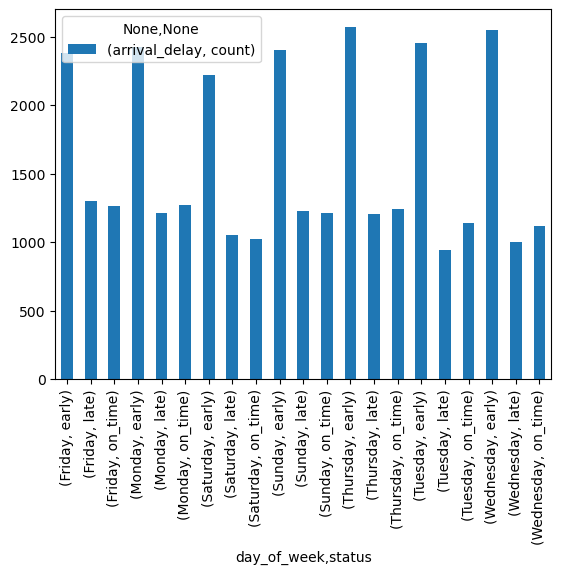

In [38]:
df[["day_of_week", "arrival_delay", 'status']].groupby(by=["day_of_week", 'status']).agg({
    "arrival_delay": ['count'],
    # "status": ['sum']
}).plot(kind="bar")

## EDA - Flight status and frequency distribution on weekdays and weekends.

In [39]:
df[["weekend", "arrival_delay", 'status']].groupby(by=["weekend", 'status']).agg({
    "arrival_delay": ['min', 'max', 'mean', 'median', 'count'],
    # "status": ['sum']
})

arrival_delay                         
                          min max   mean median  count
weekend status                                        
0       early             -55  -6 -15.30 -14.00  12389
        late                6  60  23.34  19.00   5665
        on_time            -5   5  -0.67  -1.00   6026
1       early             -51  -6 -15.29 -14.00   4619
        late                6  60  23.45  19.00   2282
        on_time            -5   5  -0.47   0.00   2234

,weekend,status,count
0,0,early,"2,477.80"
1,0,late,"1,133.00"
2,0,on_time,"1,205.20"
3,1,early,"2,309.50"
4,1,late,"1,141.00"
5,1,on_time,"1,117.00"


<Axes: xlabel='weekend,status'>

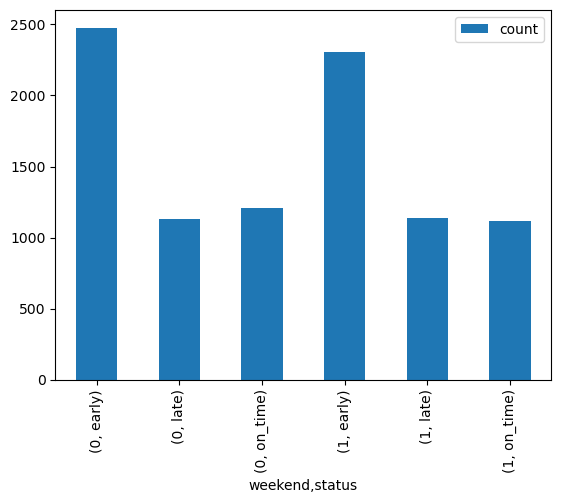

In [40]:
temp_df = df.groupby(by=["weekend", 'status']).size().reset_index(name='count')
temp_df['count'] = temp_df.groupby('weekend')['count'].transform(lambda x: x / 5 if x.name == 0 else x / 2)

temp_df

temp_df.set_index(["weekend", "status"]).plot(kind="bar")

We observe that many flights are early on weekdays and also on the weekends.

## EDA - Flight status and frequency distribution on holidays.

In [41]:
df[["is_fed_holiday", "arrival_delay", 'status']].groupby(by=["is_fed_holiday", 'status']).agg({
    "arrival_delay": ['min', 'max', 'mean', 'median', 'count'],
    # "status": ['sum']
})

arrival_delay                         
                                 min max   mean median  count
is_fed_holiday status                                        
0              early             -55  -6 -15.29 -14.00  16130
               late                6  60  23.44  19.00   7592
               on_time            -5   5  -0.61   0.00   7877
1              early             -48  -6 -15.40 -14.00    878
               late                6  60  21.87  18.00    355
               on_time            -5   5  -0.81  -1.00    383

In [42]:
total_holidays = len(holidays) + 3*13 + 3*6
total_holidays, 365*3 - total_holidays

(90, 1005)

<Axes: xlabel='is_fed_holiday,status'>

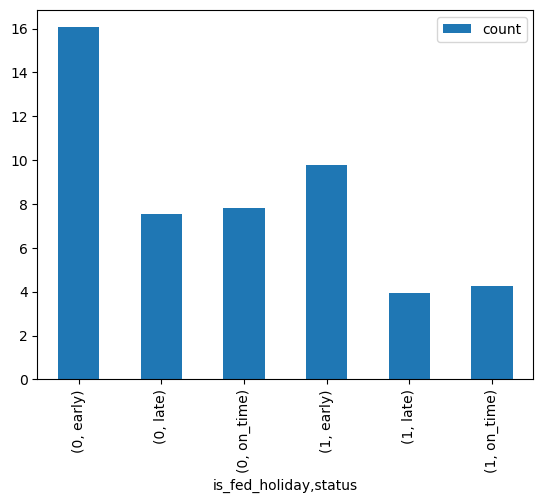

In [43]:
temp_df = df.groupby(by=["is_fed_holiday", 'status']).size().reset_index(name='count')
temp_df['count'] = temp_df.groupby('is_fed_holiday')['count'].transform(lambda x: x / 1005 if x.name == 0 else x / 90)
temp_df.set_index(["is_fed_holiday", "status"], inplace=True)

temp_df.plot(kind="bar")

## Flight status and frequency distribution on all hours of the day.

In [44]:
temp_df = df.copy()
temp_df.columns

Index(['carrier_code', 'date', 'flight_number', 'tail_number',
       'origin_airport', 'scheduled_arrival_time', 'actual_arrival_time',
       'scheduled_elapsed_time', 'actual_elapsed_time', 'arrival_delay',
       'wheels_on_time', 'taxi_in_time', 'delay_carrier', 'delay_weather',
       'delay_national_aviation_system', 'delay_security',
       'delay_late_aircraft_arrival', 'status',
       'scheduled_arrival_time_period', 'month', 'day_of_week', 'weekend',
       'snowy_month', 'is_fed_holiday', 'datetime', 'prev_flight_delay',
       'prev_flight_time_difference'],
      dtype='object')

In [45]:
temp_df.drop(columns=["scheduled_arrival_time_period"], inplace=True)

In [46]:
temp_df.head()

,carrier_code,date,flight_number,tail_number,origin_airport,scheduled_arrival_time,actual_arrival_time,scheduled_elapsed_time,actual_elapsed_time,arrival_delay,...,delay_late_aircraft_arrival,status,month,day_of_week,weekend,snowy_month,is_fed_holiday,datetime,prev_flight_delay,prev_flight_time_difference
1,9E,2021-01-01,4695,N354CA,DTW,11:49,11:35,79,65,-14,...,0,early,January,Friday,0,1,1,2021-01-01 11:49:00,early,1
2,F9,2021-01-01,2542,N232FR,TPA,12:03,11:39,163,157,-24,...,0,early,January,Friday,0,1,1,2021-01-01 12:03:00,early,1
3,OH,2021-01-01,5215,N718PS,PHL,13:49,13:27,79,60,-22,...,0,early,January,Friday,0,1,1,2021-01-01 13:49:00,early,1
4,F9,2021-01-01,1214,N220FR,MCO,17:04,17:04,170,148,0,...,0,on_time,January,Friday,0,1,1,2021-01-01 17:04:00,early,0
5,9E,2021-01-01,4851,N296PQ,JFK,18:45,18:29,76,68,-16,...,0,early,January,Friday,0,1,1,2021-01-01 18:45:00,on_time,1


In [47]:
temp_df["hour"] = temp_df["datetime"].dt.hour
temp_df.head()

,carrier_code,date,flight_number,tail_number,origin_airport,scheduled_arrival_time,actual_arrival_time,scheduled_elapsed_time,actual_elapsed_time,arrival_delay,...,status,month,day_of_week,weekend,snowy_month,is_fed_holiday,datetime,prev_flight_delay,prev_flight_time_difference,hour
1,9E,2021-01-01,4695,N354CA,DTW,11:49,11:35,79,65,-14,...,early,January,Friday,0,1,1,2021-01-01 11:49:00,early,1,11
2,F9,2021-01-01,2542,N232FR,TPA,12:03,11:39,163,157,-24,...,early,January,Friday,0,1,1,2021-01-01 12:03:00,early,1,12
3,OH,2021-01-01,5215,N718PS,PHL,13:49,13:27,79,60,-22,...,early,January,Friday,0,1,1,2021-01-01 13:49:00,early,1,13
4,F9,2021-01-01,1214,N220FR,MCO,17:04,17:04,170,148,0,...,on_time,January,Friday,0,1,1,2021-01-01 17:04:00,early,0,17
5,9E,2021-01-01,4851,N296PQ,JFK,18:45,18:29,76,68,-16,...,early,January,Friday,0,1,1,2021-01-01 18:45:00,on_time,1,18


In [48]:
temp_df.groupby(by=["hour"]).agg({
    "arrival_delay": ['min', 'max', 'mean', 'median', 'count'],
    # "status": ['sum']
})

arrival_delay                        
               min max   mean median count
hour                                      
0              -47  60  -1.81  -6.00  1627
2              -15  -4 -11.33 -15.00     3
3              -17 -17 -17.00 -17.00     1
8              -47  59  -9.63 -11.50   378
9              -39  60  -5.40  -8.00   854
10             -41  60  -5.50  -8.00  1701
11             -42  59  -4.85  -8.00  4273
12             -42  60  -5.31  -8.00  1600
13             -42  59  -4.67  -8.00  1212
14             -34  60  -1.53  -5.00  1189
15             -39  60  -1.01  -4.00  1437
16             -42  60  -3.12  -7.00  3641
17             -51  59  -3.31  -7.00  2538
18             -44  60  -0.29  -4.00  1812
19             -39  60   1.90  -1.00  1097
20             -48  60   0.49  -3.00   720
21             -40  60  -1.25  -5.00  1087
22             -51  60  -1.67  -5.00  2902
23             -55  60   0.66  -3.00  5143

<Axes: ylabel='hour'>

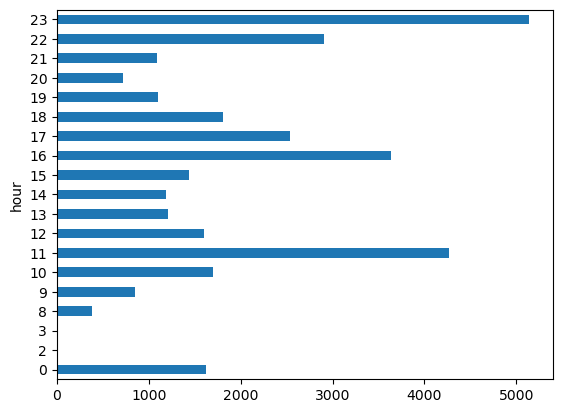

In [49]:
temp_df.groupby(by=["hour"]).size().plot(kind="barh")

In [50]:
temp_df.groupby(by=["hour", 'status']).agg({
    "arrival_delay": ['min', 'max', 'mean', 'median', 'count'],
    # "status": ['sum']
})

arrival_delay                        
                       min max   mean median count
hour status                                       
0    early             -47  -6 -16.00 -15.00   819
     late                6  60  25.11  23.00   413
     on_time            -5   5  -0.54   0.00   395
2    early             -15 -15 -15.00 -15.00     2
     on_time            -4  -4  -4.00  -4.00     1
3    early             -17 -17 -17.00 -17.00     1
8    early             -47  -6 -17.11 -15.00   256
     late                6  59  20.00  17.50    40
     on_time            -5   5  -0.74  -1.00    82
9    early             -39  -6 -16.32 -15.00   479
     late                6  60  22.35  17.00   150
     on_time            -5   5  -0.66  -1.00   225
10   early             -41  -6 -16.15 -15.00   986
     late                6  60  22.17  17.00   309
     on_time            -5   5  -0.70   0.00   406
11   early             -42  -6 -15.04 -14.00  2411
     late                6  59  20.19  16.00   817
     on_time            -5   5  -0.92  -1.00  1045
12   early             -42  -6 -14.66 -14.00   917
     late                6  60  20.34  17.00   260
     on_time            -5   5  -0.81  -1.00   423
13   early             -42  -6 -15.21 -14.00   708
     late                6  59  23.54  18.00   227
     on_time            -5   5  -0.86  -1.00   277
14   early             -34  -6 -14.55 -14.00   592
     late                6  60  23.11  19.00   298
     on_time            -5   5  -0.32   0.00   299
15   early             -39  -6 -13.93 -13.00   675
     late                6  60  21.22  17.00   383
     on_time            -5   5  -0.46   0.00   379
16   early             -42  -6 -15.16 -14.00  1931
     late                6  60  22.42  18.00   827
     on_time            -5   5  -0.71  -1.00   883
17   early             -51  -6 -15.55 -14.00  1389
     late                6  59  23.24  20.00   578
     on_time            -5   5  -0.42   0.00   571
18   early             -44  -6 -15.70 -14.00   846
     late                6  60  25.54  22.00   513
     on_time            -5   5  -0.74  -1.00   453
19   early             -39  -6 -15.43 -15.00   441
     late                6  60  24.96  21.00   359
     on_time            -5   5  -0.24   0.00   297
20   early             -48  -6 -14.84 -13.00   323
     late                6  60  25.04  22.00   209
     on_time            -5   5  -0.45   0.00   188
21   early             -40  -6 -15.58 -15.00   529
     late                6  60  24.71  20.00   283
     on_time            -5   5  -0.40   0.00   275
22   early             -51  -6 -15.17 -14.00  1432
     late                6  60  24.18  20.00   717
     on_time            -5   5  -0.62   0.00   753
23   early             -55  -6 -15.25 -14.00  2271
     late                6  60  24.71  21.00  1564
     on_time            -5   5  -0.49   0.00  1308

In [51]:
# Peak hours identified from the above distributions
peak_hours = [0, 10, 11, 16, 17, 18, 22, 23]

df["peak_hour"] = df["datetime"].dt.hour.isin(peak_hours).astype(np.int64)
df.head()

,carrier_code,date,flight_number,tail_number,origin_airport,scheduled_arrival_time,actual_arrival_time,scheduled_elapsed_time,actual_elapsed_time,arrival_delay,...,scheduled_arrival_time_period,month,day_of_week,weekend,snowy_month,is_fed_holiday,datetime,prev_flight_delay,prev_flight_time_difference,peak_hour
1,9E,2021-01-01,4695,N354CA,DTW,11:49,11:35,79,65,-14,...,morning,January,Friday,0,1,1,2021-01-01 11:49:00,early,1,1
2,F9,2021-01-01,2542,N232FR,TPA,12:03,11:39,163,157,-24,...,afternoon,January,Friday,0,1,1,2021-01-01 12:03:00,early,1,0
3,OH,2021-01-01,5215,N718PS,PHL,13:49,13:27,79,60,-22,...,afternoon,January,Friday,0,1,1,2021-01-01 13:49:00,early,1,0
4,F9,2021-01-01,1214,N220FR,MCO,17:04,17:04,170,148,0,...,evening,January,Friday,0,1,1,2021-01-01 17:04:00,early,0,1
5,9E,2021-01-01,4851,N296PQ,JFK,18:45,18:29,76,68,-16,...,evening,January,Friday,0,1,1,2021-01-01 18:45:00,on_time,1,1


# Weather

In [52]:
weather_syr = pd.read_csv("data/weather/SYR_weather_data_sub_hourly.csv")
weather_syr.head()

,app_temp,azimuth,clouds,dewpt,dhi,dni,elev_angle,ghi,pod,precip_rate,...,timestamp_utc,ts,uv,vis,weather.icon,weather.description,weather.code,wind_dir,wind_gust_spd,wind_spd
0,-6.00,354.90,87,-4.40,0,0,-69.90,0,n,0.00,...,2020-01-01T05:00:00,1577854800,0.00,16,c04n,Overcast clouds,804,260,10.80,9.30
1,-5.80,274.30,90,-4.40,0,0,-69.20,0,n,0.00,...,2020-01-01T05:15:00,1577855700,0.00,16,c04n,Overcast clouds,804,255,10.90,8.77
2,-5.60,193.70,93,-4.40,0,0,-68.50,0,n,0.00,...,2020-01-01T05:30:00,1577856600,0.00,16,c04n,Overcast clouds,804,250,11.00,8.25
3,-5.40,113.10,96,-4.40,0,0,-67.90,0,n,0.00,...,2020-01-01T05:45:00,1577857500,0.00,16,c04n,Overcast clouds,804,245,11.10,7.72
4,-5.20,32.50,100,-4.40,0,0,-67.20,0,n,0.00,...,2020-01-01T06:00:00,1577858400,0.00,16,c04n,Overcast clouds,804,240,12.90,7.20


In [53]:
weather_syr.columns

Index(['app_temp', 'azimuth', 'clouds', 'dewpt', 'dhi', 'dni', 'elev_angle',
       'ghi', 'pod', 'precip_rate', 'pres', 'revision_status', 'rh', 'slp',
       'snow_rate', 'solar_rad', 'temp', 'timestamp_local', 'timestamp_utc',
       'ts', 'uv', 'vis', 'weather.icon', 'weather.description',
       'weather.code', 'wind_dir', 'wind_gust_spd', 'wind_spd'],
      dtype='object')

In [54]:
# Drop uninformative features
weather_syr.drop(columns=["revision_status", "weather.icon", "weather.code"], inplace=True)
weather_syr.head()
weather_syr["weather.description"].unique()

,app_temp,azimuth,clouds,dewpt,dhi,dni,elev_angle,ghi,pod,precip_rate,...,temp,timestamp_local,timestamp_utc,ts,uv,vis,weather.description,wind_dir,wind_gust_spd,wind_spd
0,-6.00,354.90,87,-4.40,0,0,-69.90,0,n,0.00,...,0.60,2020-01-01T00:00:00,2020-01-01T05:00:00,1577854800,0.00,16,Overcast clouds,260,10.80,9.30
1,-5.80,274.30,90,-4.40,0,0,-69.20,0,n,0.00,...,0.60,2020-01-01T00:15:00,2020-01-01T05:15:00,1577855700,0.00,16,Overcast clouds,255,10.90,8.77
2,-5.60,193.70,93,-4.40,0,0,-68.50,0,n,0.00,...,0.60,2020-01-01T00:30:00,2020-01-01T05:30:00,1577856600,0.00,16,Overcast clouds,250,11.00,8.25
3,-5.40,113.10,96,-4.40,0,0,-67.90,0,n,0.00,...,0.60,2020-01-01T00:45:00,2020-01-01T05:45:00,1577857500,0.00,16,Overcast clouds,245,11.10,7.72
4,-5.20,32.50,100,-4.40,0,0,-67.20,0,n,0.00,...,0.60,2020-01-01T01:00:00,2020-01-01T06:00:00,1577858400,0.00,16,Overcast clouds,240,12.90,7.20


array(['Overcast clouds', 'Broken clouds', 'Scattered clouds',
       'Light rain', 'Mix snow/rain', 'Light snow', 'Flurries', 'Haze',
       'Snow', 'Moderate rain', 'Heavy rain',
       'Thunderstorm with heavy rain', 'Few clouds', 'Clear Sky',
       'Heavy sleet', 'Sleet', 'Heavy snow', 'Freezing rain', 'Fog'],
      dtype=object)

In [55]:
# Convert "weather.description" and its content into snake_case.
weather_syr["weather_description"] = weather_syr["weather.description"].apply(format_column_names)
weather_syr.drop(columns=["weather.description"], inplace=True)
weather_syr.head()

,app_temp,azimuth,clouds,dewpt,dhi,dni,elev_angle,ghi,pod,precip_rate,...,temp,timestamp_local,timestamp_utc,ts,uv,vis,wind_dir,wind_gust_spd,wind_spd,weather_description
0,-6.00,354.90,87,-4.40,0,0,-69.90,0,n,0.00,...,0.60,2020-01-01T00:00:00,2020-01-01T05:00:00,1577854800,0.00,16,260,10.80,9.30,overcast_clouds
1,-5.80,274.30,90,-4.40,0,0,-69.20,0,n,0.00,...,0.60,2020-01-01T00:15:00,2020-01-01T05:15:00,1577855700,0.00,16,255,10.90,8.77,overcast_clouds
2,-5.60,193.70,93,-4.40,0,0,-68.50,0,n,0.00,...,0.60,2020-01-01T00:30:00,2020-01-01T05:30:00,1577856600,0.00,16,250,11.00,8.25,overcast_clouds
3,-5.40,113.10,96,-4.40,0,0,-67.90,0,n,0.00,...,0.60,2020-01-01T00:45:00,2020-01-01T05:45:00,1577857500,0.00,16,245,11.10,7.72,overcast_clouds
4,-5.20,32.50,100,-4.40,0,0,-67.20,0,n,0.00,...,0.60,2020-01-01T01:00:00,2020-01-01T06:00:00,1577858400,0.00,16,240,12.90,7.20,overcast_clouds


In [56]:
weather_syr["weather_description"].unique()

array(['overcast_clouds', 'broken_clouds', 'scattered_clouds',
       'light_rain', 'mix_snow/rain', 'light_snow', 'flurries', 'haze',
       'snow', 'moderate_rain', 'heavy_rain',
       'thunderstorm_with_heavy_rain', 'few_clouds', 'clear_sky',
       'heavy_sleet', 'sleet', 'heavy_snow', 'freezing_rain', 'fog'],
      dtype=object)

In [57]:
# Remove left out special characters
weather_syr["weather_description"] = weather_syr["weather_description"].apply(lambda x: x.replace("/", "_"))
weather_syr["weather_description"].unique()

array(['overcast_clouds', 'broken_clouds', 'scattered_clouds',
       'light_rain', 'mix_snow_rain', 'light_snow', 'flurries', 'haze',
       'snow', 'moderate_rain', 'heavy_rain',
       'thunderstorm_with_heavy_rain', 'few_clouds', 'clear_sky',
       'heavy_sleet', 'sleet', 'heavy_snow', 'freezing_rain', 'fog'],
      dtype=object)

In [58]:
# Convert timestamp_local to datetime. It is a local timestamp and in the arrivals and departures data also, 
# we have the time with local time zone. So, we don't need to standardize again.
weather_syr["datetime"] = pd.to_datetime(weather_syr["timestamp_local"])
weather_syr["datetime"].min()
weather_syr["datetime"].max()

Timestamp('2020-01-01 00:00:00')

Timestamp('2024-04-07 23:45:00')

In [59]:
df["datetime"].min()

Timestamp('2021-01-01 11:49:00')

In [60]:
weather_syr[weather_syr["datetime"] >= df["datetime"].min()]

,app_temp,azimuth,clouds,dewpt,dhi,dni,elev_angle,ghi,pod,precip_rate,...,timestamp_local,timestamp_utc,ts,uv,vis,wind_dir,wind_gust_spd,wind_spd,weather_description,datetime
35184,-2.30,178.00,100,-6.10,87,748,23.90,383,d,0.00,...,2021-01-01T12:00:00,2021-01-01T17:00:00,1609520400,0.70,16,70,6.40,4.09,overcast_clouds,2021-01-01 12:00:00
35185,-2.30,181.80,100,-6.40,87,745,23.60,378,d,0.25,...,2021-01-01T12:15:00,2021-01-01T17:15:00,1609521300,0.60,16,75,6.40,4.09,overcast_clouds,2021-01-01 12:15:00
35186,-2.30,185.50,100,-6.60,86,741,23.30,373,d,0.50,...,2021-01-01T12:30:00,2021-01-01T17:30:00,1609522200,0.60,16,75,6.40,4.09,overcast_clouds,2021-01-01 12:30:00
35187,-2.30,189.30,100,-6.60,86,738,23.10,368,d,0.25,...,2021-01-01T12:45:00,2021-01-01T17:45:00,1609523100,0.60,16,80,6.40,4.09,overcast_clouds,2021-01-01 12:45:00
35188,-2.30,193.00,100,-6.80,85,735,22.80,363,d,0.00,...,2021-01-01T13:00:00,2021-01-01T18:00:00,1609524000,0.60,16,80,6.40,4.09,overcast_clouds,2021-01-01 13:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149655,6.20,318.70,0,-1.20,0,0,-30.10,0,n,0.00,...,2024-04-07T22:45:00,2024-04-08T02:45:00,1712544300,0.00,16,20,1.60,1.54,clear_sky,2024-04-07 22:45:00
149656,6.90,322.30,42,-2.20,0,0,-32.00,0,n,0.00,...,2024-04-07T23:00:00,2024-04-08T03:00:00,1712545200,0.00,16,0,1.00,1.00,broken_clouds,2024-04-07 23:00:00
149657,5.00,326.50,42,-4.20,0,0,-33.30,0,n,0.00,...,2024-04-07T23:15:00,2024-04-08T03:15:00,1712546100,0.00,16,210,1.60,1.54,broken_clouds,2024-04-07 23:15:00
149658,5.80,330.70,42,-2.10,0,0,-34.70,0,n,0.00,...,2024-04-07T23:30:00,2024-04-08T03:30:00,1712547000,0.00,16,0,1.00,1.00,broken_clouds,2024-04-07 23:30:00


In [61]:
# Sort by datetime
weather_syr.sort_values(by=["datetime"], inplace=True)
weather_syr.head()

,app_temp,azimuth,clouds,dewpt,dhi,dni,elev_angle,ghi,pod,precip_rate,...,timestamp_local,timestamp_utc,ts,uv,vis,wind_dir,wind_gust_spd,wind_spd,weather_description,datetime
0,-6.00,354.90,87,-4.40,0,0,-69.90,0,n,0.00,...,2020-01-01T00:00:00,2020-01-01T05:00:00,1577854800,0.00,16,260,10.80,9.30,overcast_clouds,2020-01-01 00:00:00
1,-5.80,274.30,90,-4.40,0,0,-69.20,0,n,0.00,...,2020-01-01T00:15:00,2020-01-01T05:15:00,1577855700,0.00,16,255,10.90,8.77,overcast_clouds,2020-01-01 00:15:00
2,-5.60,193.70,93,-4.40,0,0,-68.50,0,n,0.00,...,2020-01-01T00:30:00,2020-01-01T05:30:00,1577856600,0.00,16,250,11.00,8.25,overcast_clouds,2020-01-01 00:30:00
3,-5.40,113.10,96,-4.40,0,0,-67.90,0,n,0.00,...,2020-01-01T00:45:00,2020-01-01T05:45:00,1577857500,0.00,16,245,11.10,7.72,overcast_clouds,2020-01-01 00:45:00
4,-5.20,32.50,100,-4.40,0,0,-67.20,0,n,0.00,...,2020-01-01T01:00:00,2020-01-01T06:00:00,1577858400,0.00,16,240,12.90,7.20,overcast_clouds,2020-01-01 01:00:00


In [62]:
# Weather features to be considered initially
# Common features in historical weather data and weather forecast data
# Filter these features from original weather data
weather_cols = ["datetime", "temp",	"app_temp",	"clouds",	"precip_rate",	"rh",	"wind_spd",	"wind_gust_spd",	"wind_dir",	"weather_description",	"pres",	"slp",	"vis",	"snow_rate"]
weather_syr = weather_syr[weather_cols]

# Merge - Arrivals with Weather @ Syracuse

In [63]:
# Join arrivals data with weather at Syracuse based on the nearest observation timestamp.
df = pd.merge_asof(df, weather_syr, left_on='datetime', right_on='datetime', direction='nearest')
df.head()

,carrier_code,date,flight_number,tail_number,origin_airport,scheduled_arrival_time,actual_arrival_time,scheduled_elapsed_time,actual_elapsed_time,arrival_delay,...,precip_rate,rh,wind_spd,wind_gust_spd,wind_dir,weather_description,pres,slp,vis,snow_rate
0,9E,2021-01-01,4695,N354CA,DTW,11:49,11:35,79,65,-14,...,0.00,56,4.22,6.20,80,overcast_clouds,1014,1030,16,0.00
1,F9,2021-01-01,2542,N232FR,TPA,12:03,11:39,163,157,-24,...,0.00,56,4.09,6.40,70,overcast_clouds,1014,1030,16,0.00
2,OH,2021-01-01,5215,N718PS,PHL,13:49,13:27,79,60,-22,...,0.00,53,4.84,5.50,75,overcast_clouds,1012,1027,16,0.00
3,F9,2021-01-01,1214,N220FR,MCO,17:04,17:04,170,148,0,...,1.00,60,5.09,7.20,90,flurries,1008,1023,16,7.00
4,9E,2021-01-01,4851,N296PQ,JFK,18:45,18:29,76,68,-16,...,1.75,78,4.09,8.10,70,sleet,1007,1022,10,1.75


In [64]:
df.columns

Index(['carrier_code', 'date', 'flight_number', 'tail_number',
       'origin_airport', 'scheduled_arrival_time', 'actual_arrival_time',
       'scheduled_elapsed_time', 'actual_elapsed_time', 'arrival_delay',
       'wheels_on_time', 'taxi_in_time', 'delay_carrier', 'delay_weather',
       'delay_national_aviation_system', 'delay_security',
       'delay_late_aircraft_arrival', 'status',
       'scheduled_arrival_time_period', 'month', 'day_of_week', 'weekend',
       'snowy_month', 'is_fed_holiday', 'datetime', 'prev_flight_delay',
       'prev_flight_time_difference', 'peak_hour', 'temp', 'app_temp',
       'clouds', 'precip_rate', 'rh', 'wind_spd', 'wind_gust_spd', 'wind_dir',
       'weather_description', 'pres', 'slp', 'vis', 'snow_rate'],
      dtype='object')

In [65]:
weather_syr.columns

Index(['datetime', 'temp', 'app_temp', 'clouds', 'precip_rate', 'rh',
       'wind_spd', 'wind_gust_spd', 'wind_dir', 'weather_description', 'pres',
       'slp', 'vis', 'snow_rate'],
      dtype='object')

In [66]:
# Save the dataset as backup
df.reset_index(inplace=True, drop=True)
df.to_csv("data/aggregated/arrivals_new_features_weatherbit.csv", index=False)

In [67]:
df.columns

Index(['carrier_code', 'date', 'flight_number', 'tail_number',
       'origin_airport', 'scheduled_arrival_time', 'actual_arrival_time',
       'scheduled_elapsed_time', 'actual_elapsed_time', 'arrival_delay',
       'wheels_on_time', 'taxi_in_time', 'delay_carrier', 'delay_weather',
       'delay_national_aviation_system', 'delay_security',
       'delay_late_aircraft_arrival', 'status',
       'scheduled_arrival_time_period', 'month', 'day_of_week', 'weekend',
       'snowy_month', 'is_fed_holiday', 'datetime', 'prev_flight_delay',
       'prev_flight_time_difference', 'peak_hour', 'temp', 'app_temp',
       'clouds', 'precip_rate', 'rh', 'wind_spd', 'wind_gust_spd', 'wind_dir',
       'weather_description', 'pres', 'slp', 'vis', 'snow_rate'],
      dtype='object')

In [68]:
# define function to import viz libraries
import plotly
plotly.offline.init_notebook_mode(connected=True)
from plotly.graph_objs import *
from plotly import tools
import plotly.graph_objects as go
import seaborn as sns

correl = df.corr(numeric_only=True)

trace = go.Heatmap(z=correl.values,
                  x=correl.index.values,
                  y=correl.columns.values)
data=[trace]
plotly.offline.iplot(data, filename='basic-heatmap')

<Axes: >

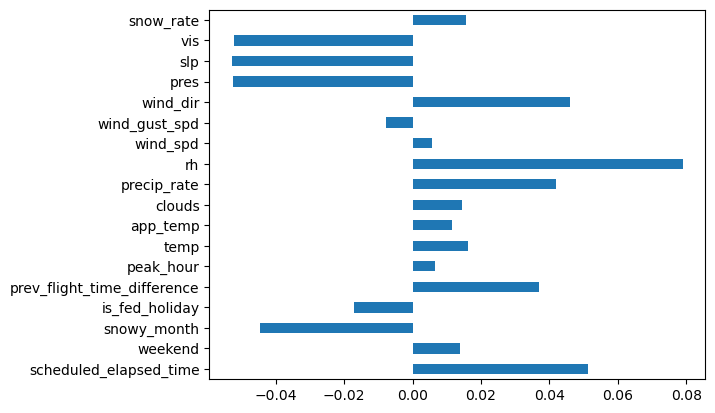

In [69]:
correl["arrival_delay"].drop(index=["delay_weather", "arrival_delay", "actual_elapsed_time", 
                                      "delay_carrier", "delay_national_aviation_system", "delay_security", 
                                      "delay_late_aircraft_arrival"]).plot(kind="barh")

In [70]:
# weather_analysis_df = df[["delay_weather", "status", 'app_temp', 'azimuth', 'clouds', 'dewpt', 'dhi', 'dni', 'elev_angle',
#        'ghi', 'pod', 'precip_rate', 'pres', 'rh', 'slp', 'snow_rate',
#        'solar_rad', 'temp', 'uv', 'vis', 'wind_dir', 'wind_gust_spd', 'wind_spd',
#        'weather_description']]
# weather_analysis_df.head()

In [71]:
# weather_analysis_df["weather_description"].unique()

In [72]:
# weather_analysis_df["status"] = weather_analysis_df["status"].apply(lambda x: -1 if x == 'early' else 1 if x=='late' else 0)
# weather_analysis_df.head()

In [73]:
# weather_analysis_df = pd.get_dummies(weather_analysis_df, dtype=np.int32)
# weather_analysis_df.head()

In [74]:
# weather_analysis_corr = weather_analysis_df.corr()
# weather_analysis_corr["delay_weather"].drop(index=["delay_weather", "status"]).plot(kind="bar", figsize=(30, 30))

In [75]:
# weather_analysis_corr = weather_analysis_df.corr()
# weather_analysis_corr["status"].drop(index=["delay_weather", "status"]).plot(kind="bar", figsize=(30, 30))

In [76]:
# weather_analysis_corr["status"].drop(index=["delay_weather", "status"]).to_frame().to_csv("weather_analysis_syr.csv")

# Departures
__Run this only after running the file "departures_weather_merge_weatherbit.ipynb"__

## MCO

In [77]:
departures_mco = pd.read_csv("data/aggregated/MCO_final_weatherbit.csv", parse_dates=True, dtype=str)
departures_mco.head()

,Carrier Code,Date (MM/DD/YYYY),Flight Number,Tail Number,Destination Airport,Scheduled departure time,Actual departure time,Scheduled elapsed time (Minutes),Actual elapsed time (Minutes),Departure delay (Minutes),...,precip_rate,rh,wind_spd,wind_gust_spd,wind_dir,weather.description,pres,slp,vis,snow_rate
0,F9,01/01/2019,1020,N201FR,SYR,12:47,12:38,160,146,-9,...,0.0,66,2.1,3.2,seg_5,Clear Sky,1015,1018,16,0
1,B6,01/01/2019,0656,N520JB,SYR,20:33,20:54,159,156,21,...,0.0,66,2.1,3.2,seg_5,Clear Sky,1015,1018,16,0
2,B6,01/02/2019,0656,N665JB,SYR,20:33,20:30,159,144,-3,...,0.0,66,2.1,3.2,seg_5,Clear Sky,1015,1018,16,0
3,F9,01/03/2019,1020,N220FR,SYR,12:47,12:41,160,153,-6,...,0.0,66,2.1,3.2,seg_5,Clear Sky,1015,1018,16,0
4,B6,01/03/2019,0656,N645JB,SYR,20:33,22:23,159,144,110,...,0.0,66,2.1,3.2,seg_5,Clear Sky,1015,1018,16,0


In [78]:
departures_mco.columns

Index(['Carrier Code', 'Date (MM/DD/YYYY)', 'Flight Number', 'Tail Number',
       'Destination Airport', 'Scheduled departure time',
       'Actual departure time', 'Scheduled elapsed time (Minutes)',
       'Actual elapsed time (Minutes)', 'Departure delay (Minutes)',
       'Wheels-off time', 'Taxi-Out time (Minutes)', 'Delay Carrier (Minutes)',
       'Delay Weather (Minutes)', 'Delay National Aviation System (Minutes)',
       'Delay Security (Minutes)', 'Delay Late Aircraft Arrival (Minutes)',
       'Origin Airport', 'datetime', 'temp', 'app_temp', 'clouds',
       'precip_rate', 'rh', 'wind_spd', 'wind_gust_spd', 'wind_dir',
       'weather.description', 'pres', 'slp', 'vis', 'snow_rate'],
      dtype='object')

## Data Cleaning

In [79]:
# Format the column names to snake_case
mapper = {
    "Date (MM/DD/YYYY)": "date",
    "Departure delay (Minutes)": "departure_delay",
    "Taxi-Out time (Minutes)": "taxi_out_time",
    "Delay Carrier (Minutes)": "delay_carrier",
    "Delay Weather (Minutes)": "delay_weather",
    "Delay National Aviation System (Minutes)": "delay_national_aviation_system",
    "Delay Security (Minutes)": "delay_security",
    "Delay Late Aircraft Arrival (Minutes)": "delay_late_aircraft_arrival",
    "Scheduled elapsed time (Minutes)": "scheduled_elapsed_time",
    "Actual elapsed time (Minutes)": "actual_elapsed_time",
    "weather.description": "weather_description"
}

departures_mco.rename(columns=mapper, inplace=True)
departures_mco.head()

departures_mco['weather_description'] = departures_mco['weather_description'].apply(lambda x: x.replace("/", "_").lower())

,Carrier Code,date,Flight Number,Tail Number,Destination Airport,Scheduled departure time,Actual departure time,scheduled_elapsed_time,actual_elapsed_time,departure_delay,...,precip_rate,rh,wind_spd,wind_gust_spd,wind_dir,weather_description,pres,slp,vis,snow_rate
0,F9,01/01/2019,1020,N201FR,SYR,12:47,12:38,160,146,-9,...,0.0,66,2.1,3.2,seg_5,Clear Sky,1015,1018,16,0
1,B6,01/01/2019,0656,N520JB,SYR,20:33,20:54,159,156,21,...,0.0,66,2.1,3.2,seg_5,Clear Sky,1015,1018,16,0
2,B6,01/02/2019,0656,N665JB,SYR,20:33,20:30,159,144,-3,...,0.0,66,2.1,3.2,seg_5,Clear Sky,1015,1018,16,0
3,F9,01/03/2019,1020,N220FR,SYR,12:47,12:41,160,153,-6,...,0.0,66,2.1,3.2,seg_5,Clear Sky,1015,1018,16,0
4,B6,01/03/2019,0656,N645JB,SYR,20:33,22:23,159,144,110,...,0.0,66,2.1,3.2,seg_5,Clear Sky,1015,1018,16,0


In [80]:
column_names = [format_column_names(x) for x in departures_mco.columns]

mapper = {}
for k, v in zip(departures_mco.columns, column_names):
    mapper[k] = v

departures_mco.rename(columns=mapper, inplace=True)
departures_mco.head()

,carrier_code,date,flight_number,tail_number,destination_airport,scheduled_departure_time,actual_departure_time,scheduled_elapsed_time,actual_elapsed_time,departure_delay,...,precip_rate,rh,wind_spd,wind_gust_spd,wind_dir,weather_description,pres,slp,vis,snow_rate
0,F9,01/01/2019,1020,N201FR,SYR,12:47,12:38,160,146,-9,...,0.0,66,2.1,3.2,seg_5,clear sky,1015,1018,16,0
1,B6,01/01/2019,0656,N520JB,SYR,20:33,20:54,159,156,21,...,0.0,66,2.1,3.2,seg_5,clear sky,1015,1018,16,0
2,B6,01/02/2019,0656,N665JB,SYR,20:33,20:30,159,144,-3,...,0.0,66,2.1,3.2,seg_5,clear sky,1015,1018,16,0
3,F9,01/03/2019,1020,N220FR,SYR,12:47,12:41,160,153,-6,...,0.0,66,2.1,3.2,seg_5,clear sky,1015,1018,16,0
4,B6,01/03/2019,0656,N645JB,SYR,20:33,22:23,159,144,110,...,0.0,66,2.1,3.2,seg_5,clear sky,1015,1018,16,0


In [81]:
departures_mco["datetime"] = pd.to_datetime(departures_mco["datetime"]) + pd.to_timedelta(departures_mco["scheduled_elapsed_time"].astype(int), "m")

In [82]:
departures_mco["date"] = pd.to_datetime(departures_mco["date"])

In [83]:
mco_df = pd.merge(
    df, 
    departures_mco.drop(columns=[
        "datetime", "tail_number", "origin_airport", "scheduled_elapsed_time", "actual_elapsed_time", 
        "delay_carrier", "delay_weather", "delay_national_aviation_system", "delay_security",
        "delay_late_aircraft_arrival"        
        ]), 
    how="inner", on=["carrier_code", "flight_number", "date"])
mco_df.head()

,carrier_code,date,flight_number,tail_number,origin_airport,scheduled_arrival_time,actual_arrival_time,scheduled_elapsed_time,actual_elapsed_time,arrival_delay,...,precip_rate_y,rh_y,wind_spd_y,wind_gust_spd_y,wind_dir_y,weather_description_y,pres_y,slp_y,vis_y,snow_rate_y
0,F9,2021-01-01,1214,N220FR,MCO,17:04,17:04,170,148,0,...,0.0,53,7.07,10.3,seg_3,broken clouds,1015,1019,16,0
1,B6,2021-01-01,0656,N646JB,MCO,23:26,23:58,156,168,32,...,0.0,81,3.22,7.2,seg_3,overcast clouds,1016,1020,16,0
2,F9,2021-01-02,1214,N334FR,MCO,17:04,16:35,170,141,-29,...,0.0,61,5.37,8.6,seg_3,overcast clouds,1014,1018,16,0
3,B6,2021-01-02,0656,N652JB,MCO,23:26,23:14,156,136,-12,...,0.0,83,2.72,4.6,seg_3,overcast clouds,1015,1018,16,0
4,F9,2021-01-03,1214,N220FR,MCO,17:16,17:01,176,164,-15,...,0.0,77,3.97,4.0,seg_6,overcast clouds,1012,1016,16,0


In [84]:
mco_df.columns

Index(['carrier_code', 'date', 'flight_number', 'tail_number',
       'origin_airport', 'scheduled_arrival_time', 'actual_arrival_time',
       'scheduled_elapsed_time', 'actual_elapsed_time', 'arrival_delay',
       'wheels_on_time', 'taxi_in_time', 'delay_carrier', 'delay_weather',
       'delay_national_aviation_system', 'delay_security',
       'delay_late_aircraft_arrival', 'status',
       'scheduled_arrival_time_period', 'month', 'day_of_week', 'weekend',
       'snowy_month', 'is_fed_holiday', 'datetime', 'prev_flight_delay',
       'prev_flight_time_difference', 'peak_hour', 'temp_x', 'app_temp_x',
       'clouds_x', 'precip_rate_x', 'rh_x', 'wind_spd_x', 'wind_gust_spd_x',
       'wind_dir_x', 'weather_description_x', 'pres_x', 'slp_x', 'vis_x',
       'snow_rate_x', 'destination_airport', 'scheduled_departure_time',
       'actual_departure_time', 'departure_delay', 'wheels_off_time',
       'taxi_out_time', 'temp_y', 'app_temp_y', 'clouds_y', 'precip_rate_y',
       'rh_y',

In [85]:
mco_df.shape

(1612, 60)

In [86]:
mco_df.to_csv("mco_full_data_weatherbit.csv", index=False)

## JFK

In [87]:
departures_jfk = pd.read_csv("data/aggregated/JFK_final_weatherbit.csv", parse_dates=True, dtype=str)
departures_jfk.head()

,Carrier Code,Date (MM/DD/YYYY),Flight Number,Tail Number,Destination Airport,Scheduled departure time,Actual departure time,Scheduled elapsed time (Minutes),Actual elapsed time (Minutes),Departure delay (Minutes),...,precip_rate,rh,wind_spd,wind_gust_spd,wind_dir,weather.description,pres,slp,vis,snow_rate
0,B6,01/01/2019,0116,N373JB,SYR,06:43,06:37,70,64,-6,...,0.0,64,7.07,11.2,seg_5,Overcast clouds,1003,1004,16,0.0
1,9E,01/01/2019,5391,N8943A,SYR,10:05,09:53,82,96,-12,...,0.0,64,7.07,11.2,seg_5,Overcast clouds,1003,1004,16,0.0
2,YX,01/01/2019,6021,N871RW,SYR,16:30,16:50,91,75,20,...,0.0,64,7.07,11.2,seg_5,Overcast clouds,1003,1004,16,0.0
3,B6,01/01/2019,2516,N374JB,SYR,17:00,16:57,77,72,-3,...,0.0,64,7.07,11.2,seg_5,Overcast clouds,1003,1004,16,0.0
4,B6,01/02/2019,0116,N192JB,SYR,06:43,07:57,70,75,74,...,0.0,64,7.07,11.2,seg_5,Overcast clouds,1003,1004,16,0.0


In [88]:
# Format the column names into snake_case
mapper = {
    "Date (MM/DD/YYYY)": "date",
    "Departure delay (Minutes)": "departure_delay",
    "Taxi-Out time (Minutes)": "taxi_out_time",
    "Delay Carrier (Minutes)": "delay_carrier",
    "Delay Weather (Minutes)": "delay_weather",
    "Delay National Aviation System (Minutes)": "delay_national_aviation_system",
    "Delay Security (Minutes)": "delay_security",
    "Delay Late Aircraft Arrival (Minutes)": "delay_late_aircraft_arrival",
    "Scheduled elapsed time (Minutes)": "scheduled_elapsed_time",
    "Actual elapsed time (Minutes)": "actual_elapsed_time",
    "weather.description": "weather_description"
}

departures_jfk.rename(columns=mapper, inplace=True)
departures_jfk.head()

,Carrier Code,date,Flight Number,Tail Number,Destination Airport,Scheduled departure time,Actual departure time,scheduled_elapsed_time,actual_elapsed_time,departure_delay,...,precip_rate,rh,wind_spd,wind_gust_spd,wind_dir,weather_description,pres,slp,vis,snow_rate
0,B6,01/01/2019,0116,N373JB,SYR,06:43,06:37,70,64,-6,...,0.0,64,7.07,11.2,seg_5,Overcast clouds,1003,1004,16,0.0
1,9E,01/01/2019,5391,N8943A,SYR,10:05,09:53,82,96,-12,...,0.0,64,7.07,11.2,seg_5,Overcast clouds,1003,1004,16,0.0
2,YX,01/01/2019,6021,N871RW,SYR,16:30,16:50,91,75,20,...,0.0,64,7.07,11.2,seg_5,Overcast clouds,1003,1004,16,0.0
3,B6,01/01/2019,2516,N374JB,SYR,17:00,16:57,77,72,-3,...,0.0,64,7.07,11.2,seg_5,Overcast clouds,1003,1004,16,0.0
4,B6,01/02/2019,0116,N192JB,SYR,06:43,07:57,70,75,74,...,0.0,64,7.07,11.2,seg_5,Overcast clouds,1003,1004,16,0.0


In [89]:
departures_jfk['weather_description'] = departures_jfk['weather_description'].apply(lambda x: x.replace("/", "_").lower())

In [90]:
column_names = [format_column_names(x) for x in departures_jfk.columns]

mapper = {}
for k, v in zip(departures_jfk.columns, column_names):
    mapper[k] = v

departures_jfk.rename(columns=mapper, inplace=True)
departures_jfk.head()

,carrier_code,date,flight_number,tail_number,destination_airport,scheduled_departure_time,actual_departure_time,scheduled_elapsed_time,actual_elapsed_time,departure_delay,...,precip_rate,rh,wind_spd,wind_gust_spd,wind_dir,weather_description,pres,slp,vis,snow_rate
0,B6,01/01/2019,0116,N373JB,SYR,06:43,06:37,70,64,-6,...,0.0,64,7.07,11.2,seg_5,overcast clouds,1003,1004,16,0.0
1,9E,01/01/2019,5391,N8943A,SYR,10:05,09:53,82,96,-12,...,0.0,64,7.07,11.2,seg_5,overcast clouds,1003,1004,16,0.0
2,YX,01/01/2019,6021,N871RW,SYR,16:30,16:50,91,75,20,...,0.0,64,7.07,11.2,seg_5,overcast clouds,1003,1004,16,0.0
3,B6,01/01/2019,2516,N374JB,SYR,17:00,16:57,77,72,-3,...,0.0,64,7.07,11.2,seg_5,overcast clouds,1003,1004,16,0.0
4,B6,01/02/2019,0116,N192JB,SYR,06:43,07:57,70,75,74,...,0.0,64,7.07,11.2,seg_5,overcast clouds,1003,1004,16,0.0


In [91]:
departures_jfk["datetime"] = pd.to_datetime(departures_jfk["datetime"]) + pd.to_timedelta(departures_jfk["scheduled_elapsed_time"].astype(int), "m")
departures_jfk["date"] = pd.to_datetime(departures_jfk["date"])

jfk_df = pd.merge(
    df, 
    departures_jfk.drop(columns=[
        "datetime", "tail_number", "origin_airport", "scheduled_elapsed_time", "actual_elapsed_time", 
        "delay_carrier", "delay_weather", "delay_national_aviation_system", "delay_security",
        "delay_late_aircraft_arrival"        
        ]), 
    how="inner", on=["carrier_code", "flight_number", "date"])
jfk_df.head()
jfk_df.shape

jfk_df.to_csv("jfk_full_data_weatherbit.csv", index=False)

,carrier_code,date,flight_number,tail_number,origin_airport,scheduled_arrival_time,actual_arrival_time,scheduled_elapsed_time,actual_elapsed_time,arrival_delay,...,precip_rate_y,rh_y,wind_spd_y,wind_gust_spd_y,wind_dir_y,weather_description_y,pres_y,slp_y,vis_y,snow_rate_y
0,9E,2021-01-01,4851,N296PQ,JFK,18:45,18:29,76,68,-16,...,1.0,80,2.85,5.2,seg_0,light rain,1026,1027,16,0.0
1,B6,2021-01-01,2516,N334JB,JFK,19:04,19:17,64,80,13,...,0.5,82,2.93,5.6,seg_0,overcast clouds,1026,1026,16,0.0
2,B6,2021-01-02,2516,N306JB,JFK,19:04,18:54,64,60,-10,...,0.0,57,6.32,7.2,seg_6,scattered clouds,1016,1016,16,0.0
3,9E,2021-01-02,4851,N918XJ,JFK,21:28,20:59,83,64,-29,...,0.0,64,5.8,6.4,seg_6,broken clouds,1017,1018,16,0.0
4,B6,2021-01-03,2516,N334JB,JFK,19:04,18:56,64,64,-8,...,1.0,90,5.82,10.4,seg_0,light rain,1013,1013,14,0.0


(3787, 60)

## ORD

In [92]:
departures_ord = pd.read_csv("data/aggregated/ORD_final_weatherbit.csv", parse_dates=True, dtype=str)
departures_ord.head()

,Carrier Code,Date (MM/DD/YYYY),Flight Number,Tail Number,Destination Airport,Scheduled departure time,Actual departure time,Scheduled elapsed time (Minutes),Actual elapsed time (Minutes),Departure delay (Minutes),...,precip_rate,rh,wind_spd,wind_gust_spd,wind_dir,weather.description,pres,slp,vis,snow_rate
0,YX,01/01/2019,3623,N651RW,SYR,09:15,09:57,104,125,42,...,0.0,84,3.6,6.4,seg_5,Scattered clouds,984,1010,16,0.0
1,MQ,01/01/2019,3538,N523AE,SYR,11:45,11:43,102,112,-2,...,0.0,84,3.6,6.4,seg_5,Scattered clouds,984,1010,16,0.0
2,OO,01/01/2019,5346,N152SY,SYR,14:00,13:59,112,126,-1,...,0.0,84,3.6,6.4,seg_5,Scattered clouds,984,1010,16,0.0
3,MQ,01/01/2019,3946,N256NN,SYR,14:47,16:30,107,121,103,...,0.0,84,3.6,6.4,seg_5,Scattered clouds,984,1010,16,0.0
4,OO,01/01/2019,5679,N135SY,SYR,18:00,19:30,112,114,90,...,0.0,84,3.6,6.4,seg_5,Scattered clouds,984,1010,16,0.0


In [93]:
# Format the column names to snake_case
mapper = {
    "Date (MM/DD/YYYY)": "date",
    "Departure delay (Minutes)": "departure_delay",
    "Taxi-Out time (Minutes)": "taxi_out_time",
    "Delay Carrier (Minutes)": "delay_carrier",
    "Delay Weather (Minutes)": "delay_weather",
    "Delay National Aviation System (Minutes)": "delay_national_aviation_system",
    "Delay Security (Minutes)": "delay_security",
    "Delay Late Aircraft Arrival (Minutes)": "delay_late_aircraft_arrival",
    "Scheduled elapsed time (Minutes)": "scheduled_elapsed_time",
    "Actual elapsed time (Minutes)": "actual_elapsed_time",
    "weather.description": "weather_description"
}

departures_ord.rename(columns=mapper, inplace=True)
departures_ord.head()

column_names = [format_column_names(x) for x in departures_ord.columns]

mapper = {}
for k, v in zip(departures_ord.columns, column_names):
    mapper[k] = v

departures_ord.rename(columns=mapper, inplace=True)
departures_ord.head()

departures_ord['weather_description'] = departures_ord['weather_description'].apply(lambda x: x.replace("/", "_").lower())

,Carrier Code,date,Flight Number,Tail Number,Destination Airport,Scheduled departure time,Actual departure time,scheduled_elapsed_time,actual_elapsed_time,departure_delay,...,precip_rate,rh,wind_spd,wind_gust_spd,wind_dir,weather_description,pres,slp,vis,snow_rate
0,YX,01/01/2019,3623,N651RW,SYR,09:15,09:57,104,125,42,...,0.0,84,3.6,6.4,seg_5,Scattered clouds,984,1010,16,0.0
1,MQ,01/01/2019,3538,N523AE,SYR,11:45,11:43,102,112,-2,...,0.0,84,3.6,6.4,seg_5,Scattered clouds,984,1010,16,0.0
2,OO,01/01/2019,5346,N152SY,SYR,14:00,13:59,112,126,-1,...,0.0,84,3.6,6.4,seg_5,Scattered clouds,984,1010,16,0.0
3,MQ,01/01/2019,3946,N256NN,SYR,14:47,16:30,107,121,103,...,0.0,84,3.6,6.4,seg_5,Scattered clouds,984,1010,16,0.0
4,OO,01/01/2019,5679,N135SY,SYR,18:00,19:30,112,114,90,...,0.0,84,3.6,6.4,seg_5,Scattered clouds,984,1010,16,0.0


,carrier_code,date,flight_number,tail_number,destination_airport,scheduled_departure_time,actual_departure_time,scheduled_elapsed_time,actual_elapsed_time,departure_delay,...,precip_rate,rh,wind_spd,wind_gust_spd,wind_dir,weather_description,pres,slp,vis,snow_rate
0,YX,01/01/2019,3623,N651RW,SYR,09:15,09:57,104,125,42,...,0.0,84,3.6,6.4,seg_5,Scattered clouds,984,1010,16,0.0
1,MQ,01/01/2019,3538,N523AE,SYR,11:45,11:43,102,112,-2,...,0.0,84,3.6,6.4,seg_5,Scattered clouds,984,1010,16,0.0
2,OO,01/01/2019,5346,N152SY,SYR,14:00,13:59,112,126,-1,...,0.0,84,3.6,6.4,seg_5,Scattered clouds,984,1010,16,0.0
3,MQ,01/01/2019,3946,N256NN,SYR,14:47,16:30,107,121,103,...,0.0,84,3.6,6.4,seg_5,Scattered clouds,984,1010,16,0.0
4,OO,01/01/2019,5679,N135SY,SYR,18:00,19:30,112,114,90,...,0.0,84,3.6,6.4,seg_5,Scattered clouds,984,1010,16,0.0


In [94]:
departures_ord["datetime"] = pd.to_datetime(departures_ord["datetime"]) + pd.to_timedelta(departures_ord["scheduled_elapsed_time"].astype(int), "m")
departures_ord["date"] = pd.to_datetime(departures_ord["date"])

ord_df = pd.merge(
    df, 
    departures_ord.drop(columns=[
        "datetime", "tail_number", "origin_airport", "scheduled_elapsed_time", "actual_elapsed_time", 
        "delay_carrier", "delay_weather", "delay_national_aviation_system", "delay_security",
        "delay_late_aircraft_arrival"        
        ]), 
    how="inner", on=["carrier_code", "flight_number", "date"])
ord_df.head()
ord_df.shape

ord_df.to_csv("ord_full_data_weatherbit.csv", index=False)

,carrier_code,date,flight_number,tail_number,origin_airport,scheduled_arrival_time,actual_arrival_time,scheduled_elapsed_time,actual_elapsed_time,arrival_delay,...,precip_rate_y,rh_y,wind_spd_y,wind_gust_spd_y,wind_dir_y,weather_description_y,pres_y,slp_y,vis_y,snow_rate_y
0,OO,2021-01-04,4708,N162SY,ORD,21:07,21:34,112,144,27,...,0.0,89,4.43,5.8,seg_4,haze,989,1013,2,0.0
1,OO,2021-01-05,4784,N213SY,ORD,21:39,21:38,114,107,-1,...,0.0,85,1.5,3.2,seg_4,overcast clouds,997,1023,10,0.0
2,OO,2021-01-06,4784,N103SY,ORD,21:39,21:22,114,107,-17,...,0.0,85,2.6,3.0,seg_0,overcast clouds,1003,1028,8,0.0
3,OO,2021-01-07,4784,N622UX,ORD,21:39,21:30,114,112,-9,...,0.0,64,4.59,6.4,seg_0,overcast clouds,1001,1027,16,0.0
4,OO,2021-01-08,4784,N145SY,ORD,21:39,22:31,114,119,52,...,0.0,75,6.2,9.8,seg_7,overcast clouds,999,1024,16,0.0


(4100, 60)

## Drop unnecessary features from the data

In [95]:
unnecessary_features = ["date", "flight_number", "tail_number", 'scheduled_arrival_time', # uninformative
       'actual_arrival_time', # not available for prediction
       'actual_elapsed_time', 'wheels_on_time', 'taxi_in_time', 'delay_carrier',
       'delay_weather', 'delay_national_aviation_system',
       'delay_security', 'delay_late_aircraft_arrival', "arrival_delay", "datetime"]

df.drop(columns=unnecessary_features, inplace=True)
df.head()

,carrier_code,origin_airport,scheduled_elapsed_time,status,scheduled_arrival_time_period,month,day_of_week,weekend,snowy_month,is_fed_holiday,...,precip_rate,rh,wind_spd,wind_gust_spd,wind_dir,weather_description,pres,slp,vis,snow_rate
0,9E,DTW,79,early,morning,January,Friday,0,1,1,...,0.00,56,4.22,6.20,80,overcast_clouds,1014,1030,16,0.00
1,F9,TPA,163,early,afternoon,January,Friday,0,1,1,...,0.00,56,4.09,6.40,70,overcast_clouds,1014,1030,16,0.00
2,OH,PHL,79,early,afternoon,January,Friday,0,1,1,...,0.00,53,4.84,5.50,75,overcast_clouds,1012,1027,16,0.00
3,F9,MCO,170,on_time,evening,January,Friday,0,1,1,...,1.00,60,5.09,7.20,90,flurries,1008,1023,16,7.00
4,9E,JFK,76,early,evening,January,Friday,0,1,1,...,1.75,78,4.09,8.10,70,sleet,1007,1022,10,1.75


In [96]:
from sklearn.preprocessing import OneHotEncoder

def get_ohe(df, col):
    if df[col].dtype == 'object':  # Check if the column contains string values
        ohe = OneHotEncoder(drop='first', handle_unknown='error',sparse_output=False, dtype='int')
        ohe.fit(df[[col]])
        temp_df = pd.DataFrame(data=ohe.transform(df[[col]]), columns=ohe.get_feature_names_out())
        df.drop(columns=[col], axis=1, inplace=True)
        df = pd.concat([df.reset_index(drop=True), temp_df], axis=1)
        return df, ohe

In [97]:
df.isna().sum()

carrier_code                     0
origin_airport                   0
scheduled_elapsed_time           0
status                           0
scheduled_arrival_time_period    0
month                            0
day_of_week                      0
weekend                          0
snowy_month                      0
is_fed_holiday                   0
prev_flight_delay                0
prev_flight_time_difference      0
peak_hour                        0
temp                             0
app_temp                         0
clouds                           0
precip_rate                      0
rh                               0
wind_spd                         0
wind_gust_spd                    0
wind_dir                         0
weather_description              0
pres                             0
slp                              0
vis                              0
snow_rate                        0
dtype: int64

In [98]:
# one hot encode the categorical features
categorical_features = ["carrier_code", "origin_airport", "scheduled_arrival_time_period", "month", "day_of_week", "prev_flight_delay", "weather_description"]

one_hots = {}

for col in categorical_features:
    df, ohe = get_ohe(df, col)
    one_hots[col] = ohe

df.head()

print(df.columns)

,scheduled_elapsed_time,status,weekend,snowy_month,is_fed_holiday,prev_flight_time_difference,peak_hour,temp,app_temp,clouds,...,weather_description_heavy_snow,weather_description_light_rain,weather_description_light_snow,weather_description_mix_snow_rain,weather_description_moderate_rain,weather_description_overcast_clouds,weather_description_scattered_clouds,weather_description_sleet,weather_description_snow,weather_description_thunderstorm_with_heavy_rain
0,79,early,0,1,1,1,1,1.70,-2.30,100,...,0,0,0,0,0,1,0,0,0,0
1,163,early,0,1,1,1,0,1.70,-2.30,100,...,0,0,0,0,0,1,0,0,0,0
2,79,early,0,1,1,1,0,1.70,-2.70,100,...,0,0,0,0,0,1,0,0,0,0
3,170,on_time,0,1,1,0,1,0.60,-4.20,100,...,0,0,0,0,0,0,0,0,0,0
4,76,early,0,1,1,1,1,0.00,-4.30,100,...,0,0,0,0,0,0,0,1,0,0


Index(['scheduled_elapsed_time', 'status', 'weekend', 'snowy_month',
       'is_fed_holiday', 'prev_flight_time_difference', 'peak_hour', 'temp',
       'app_temp', 'clouds', 'precip_rate', 'rh', 'wind_spd', 'wind_gust_spd',
       'wind_dir', 'pres', 'slp', 'vis', 'snow_rate', 'carrier_code_AA',
       'carrier_code_B6', 'carrier_code_DL', 'carrier_code_F9',
       'carrier_code_G4', 'carrier_code_MQ', 'carrier_code_OH',
       'carrier_code_OO', 'carrier_code_UA', 'carrier_code_WN',
       'carrier_code_YV', 'carrier_code_YX', 'origin_airport_BNA',
       'origin_airport_BOS', 'origin_airport_BWI', 'origin_airport_CLT',
       'origin_airport_DCA', 'origin_airport_DEN', 'origin_airport_DFW',
       'origin_airport_DTW', 'origin_airport_EWR', 'origin_airport_FLL',
       'origin_airport_GSP', 'origin_airport_IAD', 'origin_airport_JFK',
       'origin_airport_LGA', 'origin_airport_MCO', 'origin_airport_MIA',
       'origin_airport_MYR', 'origin_airport_ORD', 'origin_airport_PGD',
     

In [99]:
# Wind direction is given as angle (0-360), we are converting it into segments.
def get_wind_dir(x):
    return "seg_"+str(int((x-22.5)/45))

df["wind_dir"] = df["wind_dir"].apply(get_wind_dir)
df.head()

,scheduled_elapsed_time,status,weekend,snowy_month,is_fed_holiday,prev_flight_time_difference,peak_hour,temp,app_temp,clouds,...,weather_description_heavy_snow,weather_description_light_rain,weather_description_light_snow,weather_description_mix_snow_rain,weather_description_moderate_rain,weather_description_overcast_clouds,weather_description_scattered_clouds,weather_description_sleet,weather_description_snow,weather_description_thunderstorm_with_heavy_rain
0,79,early,0,1,1,1,1,1.70,-2.30,100,...,0,0,0,0,0,1,0,0,0,0
1,163,early,0,1,1,1,0,1.70,-2.30,100,...,0,0,0,0,0,1,0,0,0,0
2,79,early,0,1,1,1,0,1.70,-2.70,100,...,0,0,0,0,0,1,0,0,0,0
3,170,on_time,0,1,1,0,1,0.60,-4.20,100,...,0,0,0,0,0,0,0,0,0,0
4,76,early,0,1,1,1,1,0.00,-4.30,100,...,0,0,0,0,0,0,0,1,0,0


We are dropping this feature later, so, we aren't doing one-hot encoding for it.

In [100]:
df.reset_index(inplace=True, drop=True)
# Save the data as a backup
df.drop(columns=["prev_flight_delay_late", "prev_flight_delay_on_time", "prev_flight_time_difference"]).to_csv("data/aggregated/arrivals_cleaned_model_1.csv", index=False)

In [101]:
len(df)

33215

In [102]:
# Filter the data where previous flight difference is less than 1 hour. Almost all rows are present.
df = df[df["prev_flight_time_difference"] == 1]
df.drop(columns=["prev_flight_time_difference"], inplace=True)
df.head()
len(df)

,scheduled_elapsed_time,status,weekend,snowy_month,is_fed_holiday,peak_hour,temp,app_temp,clouds,precip_rate,...,weather_description_heavy_snow,weather_description_light_rain,weather_description_light_snow,weather_description_mix_snow_rain,weather_description_moderate_rain,weather_description_overcast_clouds,weather_description_scattered_clouds,weather_description_sleet,weather_description_snow,weather_description_thunderstorm_with_heavy_rain
0,79,early,0,1,1,1,1.70,-2.30,100,0.00,...,0,0,0,0,0,1,0,0,0,0
1,163,early,0,1,1,0,1.70,-2.30,100,0.00,...,0,0,0,0,0,1,0,0,0,0
2,79,early,0,1,1,0,1.70,-2.70,100,0.00,...,0,0,0,0,0,1,0,0,0,0
4,76,early,0,1,1,1,0.00,-4.30,100,1.75,...,0,0,0,0,0,0,0,1,0,0
5,116,early,0,1,1,1,-0.60,-5.70,100,3.00,...,0,0,0,0,0,0,0,1,0,0


31378

In [103]:
# backup
df.to_csv("data/aggregated/arrivals_cleaned_model_2.csv", index=False)

In [104]:
# Load predictions csv file
pred_df = pd.read_csv("data/CIS_662 _FINAL_Predictions.csv")
pred_df

,DATE,DAY,FLIGHT NUMBER,ORIGIN,DEPARTURE TIME,ARRIVAL TIME,ARRIVAL STATUS,ARRIVAL STATUS_Prev_flight_early,ARRIVAL STATUS_Prev_flight_ontime,ARRIVAL STATUS_Prev_flight_late
0,4/19/24,FRIDAY,UA 1400,ORD,6:52 PM,9:47 PM,NaN,NaN,NaN,NaN
1,4/19/24,FRIDAY,AA 3402,ORD,7:59 PM,10:52 PM,NaN,NaN,NaN,NaN
2,4/19/24,FRIDAY,B6 116,JFK,1:34 PM,2:51 PM,NaN,NaN,NaN,NaN
3,4/19/24,FRIDAY,DL 5182,JFK,2:55 PM,4:21 PM,NaN,NaN,NaN,NaN
4,4/19/24,FRIDAY,WN 5285,MCO,11:35 AM,2:20 PM,NaN,NaN,NaN,NaN
5,4/19/24,FRIDAY,B6 656,MCO,1:35 PM,4:25 PM,NaN,NaN,NaN,NaN
6,4/20/24,SATURDAY,UA 1400,ORD,6:52 PM,9:47 PM,NaN,NaN,NaN,NaN
7,4/20/24,SATURDAY,AA 3402,ORD,7:59 PM,10:52 PM,NaN,NaN,NaN,NaN
8,4/20/24,SATURDAY,B6 116,JFK,1:25 PM,2:41 PM,NaN,NaN,NaN,NaN
9,4/20/24,SATURDAY,DL 5182,JFK,2:55 PM,4:21 PM,NaN,NaN,NaN,NaN


In [105]:
# Recreate the columns as in the dataframe we made for training the model
column_names = [format_column_names(x) for x in pred_df.columns]

mapper = {}
for k, v in zip(pred_df.columns, column_names):
    mapper[k] = v

pred_df.rename(columns=mapper, inplace=True)
pred_df.head()

,date,day,flight_number,origin,departure_time,arrival_time,arrival_status,arrival_status_prev_flight_early,arrival_status_prev_flight_ontime,arrival_status_prev_flight_late
0,4/19/24,FRIDAY,UA 1400,ORD,6:52 PM,9:47 PM,NaN,NaN,NaN,NaN
1,4/19/24,FRIDAY,AA 3402,ORD,7:59 PM,10:52 PM,NaN,NaN,NaN,NaN
2,4/19/24,FRIDAY,B6 116,JFK,1:34 PM,2:51 PM,NaN,NaN,NaN,NaN
3,4/19/24,FRIDAY,DL 5182,JFK,2:55 PM,4:21 PM,NaN,NaN,NaN,NaN
4,4/19/24,FRIDAY,WN 5285,MCO,11:35 AM,2:20 PM,NaN,NaN,NaN,NaN


In [106]:
# rename the columns to maintain consistency
mapper = {
    "origin": "origin_airport",
    "departure_time": "scheduled_departure_time",
    "arrival_time": "scheduled_arrival_time",
    "arrival_status": "status"
}

pred_df.rename(columns=mapper, inplace=True)
pred_df.head()

,date,day,flight_number,origin_airport,scheduled_departure_time,scheduled_arrival_time,status,arrival_status_prev_flight_early,arrival_status_prev_flight_ontime,arrival_status_prev_flight_late
0,4/19/24,FRIDAY,UA 1400,ORD,6:52 PM,9:47 PM,NaN,NaN,NaN,NaN
1,4/19/24,FRIDAY,AA 3402,ORD,7:59 PM,10:52 PM,NaN,NaN,NaN,NaN
2,4/19/24,FRIDAY,B6 116,JFK,1:34 PM,2:51 PM,NaN,NaN,NaN,NaN
3,4/19/24,FRIDAY,DL 5182,JFK,2:55 PM,4:21 PM,NaN,NaN,NaN,NaN
4,4/19/24,FRIDAY,WN 5285,MCO,11:35 AM,2:20 PM,NaN,NaN,NaN,NaN


In [107]:
# Convert to datetime
pred_df["date"] = pd.to_datetime(pred_df["date"])

/var/folders/9q/_q4q_3y536j3lx6cc49vl0840000gn/T/ipykernel_50864/2541768084.py:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [108]:
# Same as the data cleaning & feature engineering steps done before
pred_df["scheduled_elapsed_time"] = pd.to_datetime(pred_df["scheduled_arrival_time"]) - pd.to_datetime(pred_df["scheduled_departure_time"])
pred_df["scheduled_elapsed_time"] = pred_df["scheduled_elapsed_time"].apply(lambda x: int(x.total_seconds() / 60))
pred_df.head()

/var/folders/9q/_q4q_3y536j3lx6cc49vl0840000gn/T/ipykernel_50864/114350117.py:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/var/folders/9q/_q4q_3y536j3lx6cc49vl0840000gn/T/ipykernel_50864/114350117.py:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



,date,day,flight_number,origin_airport,scheduled_departure_time,scheduled_arrival_time,status,arrival_status_prev_flight_early,arrival_status_prev_flight_ontime,arrival_status_prev_flight_late,scheduled_elapsed_time
0,2024-04-19,FRIDAY,UA 1400,ORD,6:52 PM,9:47 PM,NaN,NaN,NaN,NaN,175
1,2024-04-19,FRIDAY,AA 3402,ORD,7:59 PM,10:52 PM,NaN,NaN,NaN,NaN,173
2,2024-04-19,FRIDAY,B6 116,JFK,1:34 PM,2:51 PM,NaN,NaN,NaN,NaN,77
3,2024-04-19,FRIDAY,DL 5182,JFK,2:55 PM,4:21 PM,NaN,NaN,NaN,NaN,86
4,2024-04-19,FRIDAY,WN 5285,MCO,11:35 AM,2:20 PM,NaN,NaN,NaN,NaN,165


In [109]:
# Convert time to 24 houir format
def convert_to_24_hrs(x):
    if "AM" in x:
        return x[0:-3]

    hr, time = x.split(":")
    hr = str(int(hr) + 12)
    min = time[0:2]
    return hr+":"+min

pred_df["scheduled_departure_time"] = pred_df["scheduled_departure_time"].apply(convert_to_24_hrs)
pred_df["scheduled_arrival_time"] = pred_df["scheduled_arrival_time"].apply(convert_to_24_hrs)
pred_df.head()

,date,day,flight_number,origin_airport,scheduled_departure_time,scheduled_arrival_time,status,arrival_status_prev_flight_early,arrival_status_prev_flight_ontime,arrival_status_prev_flight_late,scheduled_elapsed_time
0,2024-04-19,FRIDAY,UA 1400,ORD,18:52,21:47,NaN,NaN,NaN,NaN,175
1,2024-04-19,FRIDAY,AA 3402,ORD,19:59,22:52,NaN,NaN,NaN,NaN,173
2,2024-04-19,FRIDAY,B6 116,JFK,13:34,14:51,NaN,NaN,NaN,NaN,77
3,2024-04-19,FRIDAY,DL 5182,JFK,14:55,16:21,NaN,NaN,NaN,NaN,86
4,2024-04-19,FRIDAY,WN 5285,MCO,11:35,14:20,NaN,NaN,NaN,NaN,165


In [110]:
# Extract time block using above defined functions
pred_df["scheduled_arrival_time_period"] = pred_df["scheduled_arrival_time"].apply(extract_time_block)
pred_df.head()

,date,day,flight_number,origin_airport,scheduled_departure_time,scheduled_arrival_time,status,arrival_status_prev_flight_early,arrival_status_prev_flight_ontime,arrival_status_prev_flight_late,scheduled_elapsed_time,scheduled_arrival_time_period
0,2024-04-19,FRIDAY,UA 1400,ORD,18:52,21:47,NaN,NaN,NaN,NaN,175,night
1,2024-04-19,FRIDAY,AA 3402,ORD,19:59,22:52,NaN,NaN,NaN,NaN,173,night
2,2024-04-19,FRIDAY,B6 116,JFK,13:34,14:51,NaN,NaN,NaN,NaN,77,afternoon
3,2024-04-19,FRIDAY,DL 5182,JFK,14:55,16:21,NaN,NaN,NaN,NaN,86,evening
4,2024-04-19,FRIDAY,WN 5285,MCO,11:35,14:20,NaN,NaN,NaN,NaN,165,afternoon


In [111]:
# Extract peak_hour using above defined functions
pred_df["peak_hour"] = pred_df["scheduled_arrival_time"].apply(lambda x: int(int(x[0:2]) in peak_hours))
pred_df.head()

,date,day,flight_number,origin_airport,scheduled_departure_time,scheduled_arrival_time,status,arrival_status_prev_flight_early,arrival_status_prev_flight_ontime,arrival_status_prev_flight_late,scheduled_elapsed_time,scheduled_arrival_time_period,peak_hour
0,2024-04-19,FRIDAY,UA 1400,ORD,18:52,21:47,NaN,NaN,NaN,NaN,175,night,0
1,2024-04-19,FRIDAY,AA 3402,ORD,19:59,22:52,NaN,NaN,NaN,NaN,173,night,1
2,2024-04-19,FRIDAY,B6 116,JFK,13:34,14:51,NaN,NaN,NaN,NaN,77,afternoon,0
3,2024-04-19,FRIDAY,DL 5182,JFK,14:55,16:21,NaN,NaN,NaN,NaN,86,evening,1
4,2024-04-19,FRIDAY,WN 5285,MCO,11:35,14:20,NaN,NaN,NaN,NaN,165,afternoon,0


In [112]:
# Recreate the features - month, day_of_week, weekend, snowy_month, is_fed_holiday
pred_df["month"] = pd.to_datetime(pred_df["date"]).dt.month_name()
pred_df["day_of_week"] = pd.to_datetime(pred_df["date"]).dt.day_name()
pred_df["weekend"] = pred_df["day_of_week"].apply(is_weekend)
pred_df["snowy_month"] = pred_df["month"].apply(snowy_month)
holidays = cal.holidays(start=pred_df["date"].min(), end=pred_df["date"].max(), return_name=True)#.to_pydatetime()
pred_df["is_fed_holiday"] = pred_df["date"].apply(is_holiday)
pred_df.head()

,date,day,flight_number,origin_airport,scheduled_departure_time,scheduled_arrival_time,status,arrival_status_prev_flight_early,arrival_status_prev_flight_ontime,arrival_status_prev_flight_late,scheduled_elapsed_time,scheduled_arrival_time_period,peak_hour,month,day_of_week,weekend,snowy_month,is_fed_holiday
0,2024-04-19,FRIDAY,UA 1400,ORD,18:52,21:47,NaN,NaN,NaN,NaN,175,night,0,April,Friday,0,0,0
1,2024-04-19,FRIDAY,AA 3402,ORD,19:59,22:52,NaN,NaN,NaN,NaN,173,night,1,April,Friday,0,0,0
2,2024-04-19,FRIDAY,B6 116,JFK,13:34,14:51,NaN,NaN,NaN,NaN,77,afternoon,0,April,Friday,0,0,0
3,2024-04-19,FRIDAY,DL 5182,JFK,14:55,16:21,NaN,NaN,NaN,NaN,86,evening,1,April,Friday,0,0,0
4,2024-04-19,FRIDAY,WN 5285,MCO,11:35,14:20,NaN,NaN,NaN,NaN,165,afternoon,0,April,Friday,0,0,0


In [113]:
# Extract carrier_code and flight_number
pred_df["carrier_code"] = pred_df["flight_number"].apply(lambda x: x.split()[0])
pred_df.head()

,date,day,flight_number,origin_airport,scheduled_departure_time,scheduled_arrival_time,status,arrival_status_prev_flight_early,arrival_status_prev_flight_ontime,arrival_status_prev_flight_late,scheduled_elapsed_time,scheduled_arrival_time_period,peak_hour,month,day_of_week,weekend,snowy_month,is_fed_holiday,carrier_code
0,2024-04-19,FRIDAY,UA 1400,ORD,18:52,21:47,NaN,NaN,NaN,NaN,175,night,0,April,Friday,0,0,0,UA
1,2024-04-19,FRIDAY,AA 3402,ORD,19:59,22:52,NaN,NaN,NaN,NaN,173,night,1,April,Friday,0,0,0,AA
2,2024-04-19,FRIDAY,B6 116,JFK,13:34,14:51,NaN,NaN,NaN,NaN,77,afternoon,0,April,Friday,0,0,0,B6
3,2024-04-19,FRIDAY,DL 5182,JFK,14:55,16:21,NaN,NaN,NaN,NaN,86,evening,1,April,Friday,0,0,0,DL
4,2024-04-19,FRIDAY,WN 5285,MCO,11:35,14:20,NaN,NaN,NaN,NaN,165,afternoon,0,April,Friday,0,0,0,WN


In [114]:
unnecessary_features

['date',
 'flight_number',
 'tail_number',
 'scheduled_arrival_time',
 'actual_arrival_time',
 'actual_elapsed_time',
 'wheels_on_time',
 'taxi_in_time',
 'delay_carrier',
 'delay_weather',
 'delay_national_aviation_system',
 'delay_security',
 'delay_late_aircraft_arrival',
 'arrival_delay',
 'datetime']

## Merge weather data with the prediction dataframe

In [115]:
pred_df["scheduled_arrival_time"] = pd.to_datetime(pred_df["date"].astype(str) + " " + pred_df["scheduled_arrival_time"])
pred_df["scheduled_departure_time"] = pd.to_datetime(pred_df["date"].astype(str) + " " + pred_df["scheduled_departure_time"])

pred_df.head()

,date,day,flight_number,origin_airport,scheduled_departure_time,scheduled_arrival_time,status,arrival_status_prev_flight_early,arrival_status_prev_flight_ontime,arrival_status_prev_flight_late,scheduled_elapsed_time,scheduled_arrival_time_period,peak_hour,month,day_of_week,weekend,snowy_month,is_fed_holiday,carrier_code
0,2024-04-19,FRIDAY,UA 1400,ORD,2024-04-19 18:52:00,2024-04-19 21:47:00,NaN,NaN,NaN,NaN,175,night,0,April,Friday,0,0,0,UA
1,2024-04-19,FRIDAY,AA 3402,ORD,2024-04-19 19:59:00,2024-04-19 22:52:00,NaN,NaN,NaN,NaN,173,night,1,April,Friday,0,0,0,AA
2,2024-04-19,FRIDAY,B6 116,JFK,2024-04-19 13:34:00,2024-04-19 14:51:00,NaN,NaN,NaN,NaN,77,afternoon,0,April,Friday,0,0,0,B6
3,2024-04-19,FRIDAY,DL 5182,JFK,2024-04-19 14:55:00,2024-04-19 16:21:00,NaN,NaN,NaN,NaN,86,evening,1,April,Friday,0,0,0,DL
4,2024-04-19,FRIDAY,WN 5285,MCO,2024-04-19 11:35:00,2024-04-19 14:20:00,NaN,NaN,NaN,NaN,165,afternoon,0,April,Friday,0,0,0,WN


In [116]:
pred_df.sort_values(by=["scheduled_arrival_time"], inplace=True)

In [117]:
# weather forecast data
df_w = pd.read_csv("weather_forecast_data.csv")
df_w.head()

,datetime,timestamp_local,temp,app_temp,clouds,precip,rh,wind_spd,wind_gust_spd,wind_dir,weather_description,pres,slp,vis,snow,Location
0,2024-04-19:04,2024-04-19T00:00:00,8.00,8.00,74,0.00,73,4.40,6.80,60,Overcast clouds,"1,020.50","1,020.60",15.70,0,JFK
1,2024-04-19:04,2024-04-19T00:00:00,22.40,22.70,12,0.00,76,1.60,2.80,150,Few clouds,"1,014.00","1,016.80",20.80,0,MCO
2,2024-04-19:05,2024-04-19T00:00:00,9.50,9.50,87,0.50,84,4.00,6.00,340,Overcast clouds,992.00,"1,016.50",14.30,0,ORD
3,2024-04-19:04,2024-04-19T00:00:00,10.00,10.00,84,0.00,79,3.20,4.80,100,Overcast clouds,"1,001.50","1,017.00",14.00,0,SYR
4,2024-04-19:05,2024-04-19T01:00:00,7.90,7.90,72,0.00,74,4.40,6.40,60,Overcast clouds,"1,020.50","1,020.60",14.50,0,JFK


In [118]:
df_w.rename(columns={"precip": "precip_rate", "snow": "snow_rate"}, inplace=True)

In [119]:
weather_jfk = df_w[df_w["Location"]=="JFK"].drop(columns=["Location"])
weather_ord = df_w[df_w["Location"]=="ORD"].drop(columns=["Location"])
weather_mco = df_w[df_w["Location"]=="MCO"].drop(columns=["Location"])
weather_syr_f = df_w[df_w["Location"]=="SYR"].drop(columns=["Location"])

weather_mco["datetime"] = pd.to_datetime(weather_mco["timestamp_local"])
weather_ord["datetime"] = pd.to_datetime(weather_ord["timestamp_local"])
weather_jfk["datetime"] = pd.to_datetime(weather_jfk["timestamp_local"])
weather_syr_f["datetime"] = pd.to_datetime(weather_syr_f["timestamp_local"])

weather_mco.drop(columns=["timestamp_local"], inplace=True)
weather_ord.drop(columns=["timestamp_local"], inplace=True)
weather_jfk.drop(columns=["timestamp_local"], inplace=True)
weather_syr_f.drop(columns=["timestamp_local"], inplace=True)

weather_mco.rename(columns={"weather.description": "weather_description"},  inplace=True)
weather_ord.rename(columns={"weather.description": "weather_description"},  inplace=True)
weather_jfk.rename(columns={"weather.description": "weather_description"},  inplace=True)
weather_syr_f.rename(columns={"weather.description": "weather_description"},  inplace=True)

weather_mco["weather_description"] = weather_mco["weather_description"].apply(lambda x: x.replace("/", "_").lower())
weather_ord["weather_description"] = weather_ord["weather_description"].apply(lambda x: x.replace("/", "_").lower())
weather_jfk["weather_description"] = weather_jfk["weather_description"].apply(lambda x: x.replace("/", "_").lower())
weather_syr_f["weather_description"] = weather_syr_f["weather_description"].apply(lambda x: x.replace("/", "_").lower())

In [120]:
pred_df = pd.merge_asof(pred_df, weather_syr_f, left_on='scheduled_arrival_time', right_on='datetime', direction='nearest')
pred_df.head()

,date,day,flight_number,origin_airport,scheduled_departure_time,scheduled_arrival_time,status,arrival_status_prev_flight_early,arrival_status_prev_flight_ontime,arrival_status_prev_flight_late,...,precip_rate,rh,wind_spd,wind_gust_spd,wind_dir,weather_description,pres,slp,vis,snow_rate
0,2024-04-19,FRIDAY,WN 5285,MCO,2024-04-19 11:35:00,2024-04-19 14:20:00,NaN,NaN,NaN,NaN,...,0.50,55,9.20,14.20,170,overcast clouds,996.00,"1,011.20",13.30,0
1,2024-04-19,FRIDAY,B6 116,JFK,2024-04-19 13:34:00,2024-04-19 14:51:00,NaN,NaN,NaN,NaN,...,0.76,57,9.20,13.70,180,drizzle,996.00,"1,011.20",4.40,0
2,2024-04-19,FRIDAY,DL 5182,JFK,2024-04-19 14:55:00,2024-04-19 16:21:00,NaN,NaN,NaN,NaN,...,0.76,58,9.60,14.40,180,drizzle,996.00,"1,011.20",16.59,0
3,2024-04-19,FRIDAY,B6 656,MCO,2024-04-19 13:35:00,2024-04-19 16:25:00,NaN,NaN,NaN,NaN,...,0.76,58,9.60,14.40,180,drizzle,996.00,"1,011.20",16.59,0
4,2024-04-19,FRIDAY,UA 1400,ORD,2024-04-19 18:52:00,2024-04-19 21:47:00,NaN,NaN,NaN,NaN,...,0.25,72,5.60,8.60,260,broken clouds,"1,000.00","1,015.50",20.90,0


In [121]:
pred_df.sort_values(by=["scheduled_departure_time"], inplace=True)

In [122]:
# Separate the prediction files into three different csv files as backup
pred_df_jfk = pred_df[pred_df["origin_airport"]=="JFK"]
pred_df_ord = pred_df[pred_df["origin_airport"]=="ORD"]
pred_df_mco = pred_df[pred_df["origin_airport"]=="MCO"]

In [123]:
pred_df_jfk = pd.merge_asof(pred_df_jfk, weather_jfk, left_on="scheduled_departure_time", right_on='datetime', direction='nearest')
pred_df_ord = pd.merge_asof(pred_df_ord, weather_ord, left_on="scheduled_departure_time", right_on='datetime', direction='nearest')
pred_df_mco = pd.merge_asof(pred_df_mco, weather_mco, left_on="scheduled_departure_time", right_on='datetime', direction='nearest')

pred_df = pd.concat([pred_df_jfk, pred_df_ord, pred_df_mco])
pred_df.sort_values(by=["scheduled_arrival_time"], inplace=True)

In [124]:
pred_df.head()

,date,day,flight_number,origin_airport,scheduled_departure_time,scheduled_arrival_time,status,arrival_status_prev_flight_early,arrival_status_prev_flight_ontime,arrival_status_prev_flight_late,...,precip_rate_y,rh_y,wind_spd_y,wind_gust_spd_y,wind_dir_y,weather_description_y,pres_y,slp_y,vis_y,snow_rate_y
0,2024-04-19,FRIDAY,WN 5285,MCO,2024-04-19 11:35:00,2024-04-19 14:20:00,NaN,NaN,NaN,NaN,...,0.00,50,2.00,2.80,290,few clouds,"1,014.00","1,016.70",24.00,0
0,2024-04-19,FRIDAY,B6 116,JFK,2024-04-19 13:34:00,2024-04-19 14:51:00,NaN,NaN,NaN,NaN,...,0.00,61,5.60,7.40,120,overcast clouds,"1,020.00","1,020.10",24.00,0
1,2024-04-19,FRIDAY,DL 5182,JFK,2024-04-19 14:55:00,2024-04-19 16:21:00,NaN,NaN,NaN,NaN,...,0.00,63,5.20,7.30,130,overcast clouds,"1,020.00","1,020.10",24.00,0
1,2024-04-19,FRIDAY,B6 656,MCO,2024-04-19 13:35:00,2024-04-19 16:25:00,NaN,NaN,NaN,NaN,...,0.00,40,2.80,4.20,280,few clouds,"1,012.50","1,015.20",24.00,0
0,2024-04-19,FRIDAY,UA 1400,ORD,2024-04-19 18:52:00,2024-04-19 21:47:00,NaN,NaN,NaN,NaN,...,0.00,38,7.20,11.00,280,broken clouds,996.50,"1,021.10",24.00,0


In [125]:
pred_df.columns

Index(['date', 'day', 'flight_number', 'origin_airport',
       'scheduled_departure_time', 'scheduled_arrival_time', 'status',
       'arrival_status_prev_flight_early', 'arrival_status_prev_flight_ontime',
       'arrival_status_prev_flight_late', 'scheduled_elapsed_time',
       'scheduled_arrival_time_period', 'peak_hour', 'month', 'day_of_week',
       'weekend', 'snowy_month', 'is_fed_holiday', 'carrier_code',
       'datetime_x', 'temp_x', 'app_temp_x', 'clouds_x', 'precip_rate_x',
       'rh_x', 'wind_spd_x', 'wind_gust_spd_x', 'wind_dir_x',
       'weather_description_x', 'pres_x', 'slp_x', 'vis_x', 'snow_rate_x',
       'datetime_y', 'temp_y', 'app_temp_y', 'clouds_y', 'precip_rate_y',
       'rh_y', 'wind_spd_y', 'wind_gust_spd_y', 'wind_dir_y',
       'weather_description_y', 'pres_y', 'slp_y', 'vis_y', 'snow_rate_y'],
      dtype='object')

In [126]:
unnecessary_features = ["date", "day", "flight_number", "scheduled_arrival_time"] #scheduled_departure_time
unnecessary_features

['date', 'day', 'flight_number', 'scheduled_arrival_time']

In [127]:
pred_df.drop(columns=unnecessary_features, inplace=True)
pred_df.head()
pred_df.columns

,origin_airport,scheduled_departure_time,status,arrival_status_prev_flight_early,arrival_status_prev_flight_ontime,arrival_status_prev_flight_late,scheduled_elapsed_time,scheduled_arrival_time_period,peak_hour,month,...,precip_rate_y,rh_y,wind_spd_y,wind_gust_spd_y,wind_dir_y,weather_description_y,pres_y,slp_y,vis_y,snow_rate_y
0,MCO,2024-04-19 11:35:00,NaN,NaN,NaN,NaN,165,afternoon,0,April,...,0.00,50,2.00,2.80,290,few clouds,"1,014.00","1,016.70",24.00,0
0,JFK,2024-04-19 13:34:00,NaN,NaN,NaN,NaN,77,afternoon,0,April,...,0.00,61,5.60,7.40,120,overcast clouds,"1,020.00","1,020.10",24.00,0
1,JFK,2024-04-19 14:55:00,NaN,NaN,NaN,NaN,86,evening,1,April,...,0.00,63,5.20,7.30,130,overcast clouds,"1,020.00","1,020.10",24.00,0
1,MCO,2024-04-19 13:35:00,NaN,NaN,NaN,NaN,170,evening,1,April,...,0.00,40,2.80,4.20,280,few clouds,"1,012.50","1,015.20",24.00,0
0,ORD,2024-04-19 18:52:00,NaN,NaN,NaN,NaN,175,night,0,April,...,0.00,38,7.20,11.00,280,broken clouds,996.50,"1,021.10",24.00,0


Index(['origin_airport', 'scheduled_departure_time', 'status',
       'arrival_status_prev_flight_early', 'arrival_status_prev_flight_ontime',
       'arrival_status_prev_flight_late', 'scheduled_elapsed_time',
       'scheduled_arrival_time_period', 'peak_hour', 'month', 'day_of_week',
       'weekend', 'snowy_month', 'is_fed_holiday', 'carrier_code',
       'datetime_x', 'temp_x', 'app_temp_x', 'clouds_x', 'precip_rate_x',
       'rh_x', 'wind_spd_x', 'wind_gust_spd_x', 'wind_dir_x',
       'weather_description_x', 'pres_x', 'slp_x', 'vis_x', 'snow_rate_x',
       'datetime_y', 'temp_y', 'app_temp_y', 'clouds_y', 'precip_rate_y',
       'rh_y', 'wind_spd_y', 'wind_gust_spd_y', 'wind_dir_y',
       'weather_description_y', 'pres_y', 'slp_y', 'vis_y', 'snow_rate_y'],
      dtype='object')

In [128]:
categorical_features

['carrier_code',
 'origin_airport',
 'scheduled_arrival_time_period',
 'month',
 'day_of_week',
 'prev_flight_delay',
 'weather_description']

In [129]:
one_hots

{'carrier_code': OneHotEncoder(drop='first', dtype='int', sparse_output=False),
 'origin_airport': OneHotEncoder(drop='first', dtype='int', sparse_output=False),
 'scheduled_arrival_time_period': OneHotEncoder(drop='first', dtype='int', sparse_output=False),
 'month': OneHotEncoder(drop='first', dtype='int', sparse_output=False),
 'day_of_week': OneHotEncoder(drop='first', dtype='int', sparse_output=False),
 'prev_flight_delay': OneHotEncoder(drop='first', dtype='int', sparse_output=False),
 'weather_description': OneHotEncoder(drop='first', dtype='int', sparse_output=False)}

In [130]:
# one_hots["weather_description"].transform(pred_df["weather_description"])

In [131]:
# categorical_features = ["weather_description"] #categorical_features[0:-3]

# for col in categorical_features:
#     # pred_df = get_ohe(pred_df, col)


# pred_df.head()

In [132]:
original_columns = ord_df.columns.to_list()
original_columns

['carrier_code',
 'date',
 'flight_number',
 'tail_number',
 'origin_airport',
 'scheduled_arrival_time',
 'actual_arrival_time',
 'scheduled_elapsed_time',
 'actual_elapsed_time',
 'arrival_delay',
 'wheels_on_time',
 'taxi_in_time',
 'delay_carrier',
 'delay_weather',
 'delay_national_aviation_system',
 'delay_security',
 'delay_late_aircraft_arrival',
 'status',
 'scheduled_arrival_time_period',
 'month',
 'day_of_week',
 'weekend',
 'snowy_month',
 'is_fed_holiday',
 'datetime',
 'prev_flight_delay',
 'prev_flight_time_difference',
 'peak_hour',
 'temp_x',
 'app_temp_x',
 'clouds_x',
 'precip_rate_x',
 'rh_x',
 'wind_spd_x',
 'wind_gust_spd_x',
 'wind_dir_x',
 'weather_description_x',
 'pres_x',
 'slp_x',
 'vis_x',
 'snow_rate_x',
 'destination_airport',
 'scheduled_departure_time',
 'actual_departure_time',
 'departure_delay',
 'wheels_off_time',
 'taxi_out_time',
 'temp_y',
 'app_temp_y',
 'clouds_y',
 'precip_rate_y',
 'rh_y',
 'wind_spd_y',
 'wind_gust_spd_y',
 'wind_dir_y',
 '

In [133]:
missing_columns = [x for x in original_columns if x not in pred_df.columns]
missing_columns

['date',
 'flight_number',
 'tail_number',
 'scheduled_arrival_time',
 'actual_arrival_time',
 'actual_elapsed_time',
 'arrival_delay',
 'wheels_on_time',
 'taxi_in_time',
 'delay_carrier',
 'delay_weather',
 'delay_national_aviation_system',
 'delay_security',
 'delay_late_aircraft_arrival',
 'datetime',
 'prev_flight_delay',
 'prev_flight_time_difference',
 'destination_airport',
 'actual_departure_time',
 'departure_delay',
 'wheels_off_time',
 'taxi_out_time']

All missing columns are unnecessary features that we'll remove again. So, we're good.

In [134]:
# pred_df[missing_columns] = 0
# pred_df.head()

In [135]:
# # pred_df_1 = pred_df[original_columns]
# pred_df_1 = pred_df
# pred_df_1.drop(columns=['prev_flight_delay_late', 'prev_flight_delay_on_time'], inplace=True)
# pred_df_1.head()

In [136]:
pred_df.to_csv("prediction_part_1.csv", index=False)

In [137]:
pred_df_2 = pred_df.copy()
pred_df_2["prev_flight_delay_late"] = 0
pred_df_2["prev_flight_delay_on_time"] = 0
pred_df_2.to_csv("pred_2.csv", index=False)

In [138]:
pred_df_3 = pred_df.copy()
pred_df_3["prev_flight_delay_late"] = 1
pred_df_3["prev_flight_delay_on_time"] = 0
pred_df_3.to_csv("pred_3.csv", index=False)

In [139]:
pred_df_4 = pred_df.copy()
pred_df_4["prev_flight_delay_late"] = 1
pred_df_4["prev_flight_delay_on_time"] = 0
pred_df_4.to_csv("pred_4.csv", index=False)

In [140]:
# pred_df_1.to_csv("data/pred/pred_1.csv", index=False)
# pred_df_2.to_csv("data/pred/pred_2.csv", index=False)
# pred_df_3.to_csv("data/pred/pred_3.csv", index=False)
# pred_df_4.to_csv("data/pred/pred_4.csv", index=False)